   # Getting Started with Toppic Modelling 

This section introduces the basic concepts and terms needed to understand and use `gensim` and provides a simple usage example.

## Core Concepts and Simple Example

At a very high-level, `gensim` is a tool for discovering the semantic structure of documents by examining the patterns of words (or higher-level structures such as entire sentences or documents). `gensim` accomplishes this by taking a *corpus*, a collection of text documents, and producing a *vector* representation of the text in the corpus. The vector representation can then be used to train a *model*, which is an algorithms to create different representations of the data, which are usually more semantic. These three concepts are key to understanding how `gensim` works so let's take a moment to explain what each of them means. At the same time, we'll work through a simple example that illustrates each of them.

### Corpus

A *corpus* is a collection of digital documents. This collection is the input to `gensim` from which it will infer the structure of the documents, their topics, etc. The latent structure inferred from the corpus can later be used to assign topics to new documents which were not present in the training corpus. For this reason, we also refer to this collection as the *training corpus*. No human intervention (such as tagging the documents by hand) is required - the topic classification is [unsupervised](https://en.wikipedia.org/wiki/Unsupervised_learning).

For our corpus, we'll use a list of 9 strings, each consisting of only a single sentence.

In [87]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

In [88]:
# Install: pip install spacy && python -m spacy download en
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en')



    Only loading the 'en' tokenizer.



In [90]:
# Create a set of frequent words
stoplist = set('xender audio dcim camera new anyshare vidmate dcim web media naat ali xender telegram vid pictures vid the and file files storage ami naat tel folder home download bhd sha www version any full part com status gps data lenovo whatsapp android hdrip xvid evo official file shareit eid'.split())
# Lowercase each document, split it by white space and filter out stopwords
data = [line.strip() for line in open("ml_topic_modelling_100k.txt", 'r')]
texts = [[word.lower() for word in text.split() if word not in stoplist] for text in data]
# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        if(len(token) > 2):
            frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]

Before proceeding, we want to associate each word in the corpus with a unique integer ID. We can do this using the `gensim.corpora.Dictionary` class. This dictionary defines the vocabulary of all words that our processing knows about.

In [91]:
import logging

In [92]:
logging.basicConfig(level=logging.DEBUG)

In [93]:
from gensim import corpora
dictionary = corpora.Dictionary(processed_corpus)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(11854 unique tokens: ['"file', 'comedy', 'drama', 'eid', 'iftikhar']...)
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary(17365 unique tokens: ['"file', 'comedy', 'drama', 'eid', 'iftikhar']...)
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary(20678 unique tokens: ['"file', 'comedy', 'drama', 'eid', 'iftikhar']...)
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary(22978 unique tokens: ['"file', 'comedy', 'drama', 'eid', 'iftikhar']...)
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary(24814 unique tokens: ['"file', 'comedy', 'drama', 'eid', 'iftikhar']...)
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary(26484 unique tokens: ['"file', 'comedy', 'drama', 'eid', 'iftikhar']...)
INFO:gensim.corpora.dictionary:adding document #70000 to Dictionary(2

Because our corpus is small, there is only 12 different tokens in this `Dictionary`. For larger corpuses, dictionaries that contains hundreds of thousands of tokens are quite common.

### Vector

To infer the latent structure in our corpus we need a way to represent documents that we can manipulate mathematically. One approach is to represent each document as a vector. There are various approaches for creating a vector representation of a document but a simple example is the *bag-of-words model*. Under the bag-of-words model each document is represented by a vector containing the frequency counts of each word in the dictionary. For example, given a dictionary containing the words `['coffee', 'milk', 'sugar', 'spoon']` a document consisting of the string `"coffee milk coffee"` could be represented by the vector `[2, 1, 0, 0]` where the entries of the vector are (in order) the occurrences of "coffee", "milk", "sugar" and "spoon" in the document. The length of the vector is the number of entries in the dictionary. One of the main properties of the bag-of-words model is that it completely ignores the order of the tokens in the document that is encoded, which is where the name bag-of-words comes from.

Our processed corpus has 12 unique words in it, which means that each document will be represented by a 12-dimensional vector under the bag-of-words model. We can use the dictionary to turn tokenized documents into these 12-dimensional vectors. We can see what these IDs correspond to:

In [94]:
#print(dictionary.token2id)

Note that "interaction" did not occur in the original corpus and so it was not included in the vectorization. Also note that this vector only contains entries for words that actually appeared in the document. Because any given document will only contain a few words out of the many words in the dictionary, words that do not appear in the vectorization are represented as implicitly zero as a space saving measure.

We can convert our entire original corpus to a list of vectors:

In [95]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
#bow_corpus

Note that while this list lives entirely in memory, in most applications you will want a more scalable solution. Luckily, `gensim` allows you to use any iterator that returns a single document vector at a time. See the documentation for more details.

### Model

Now that we have vectorized our corpus we can begin to transform it using *models*. We use model as an abstract term referring to a transformation from one document representation to another. In `gensim`, documents are represented as vectors so a model can be thought of as a transformation between two [vector spaces](https://en.wikipedia.org/wiki/Vector_space). The details of this transformation are learned from the training corpus.

One simple example of a model is [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).  The tf-idf model transforms vectors from the bag-of-words representation to a vector space, where the frequency counts are weighted according to the relative rarity of each word in the corpus.

Here's a simple example. Let's initialize the tf-idf model, training it on our corpus and transforming the string "system minors":

In [97]:
from gensim import models
# train the model
tfidf = models.TfidfModel(bow_corpus)
# transform the "system minors" string
tfidf[dictionary.doc2bow("comedy minors".lower().split())]

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #10000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #20000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #30000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #40000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #50000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #60000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #70000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #80000
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #90000
INFO:gensim.models.tfidfmodel:calculating IDF weights for 100000 documents and 30330 features (902271 matrix non-zeros)


[(1, 1.0)]

In [98]:
corpus = [dictionary.doc2bow(text) for text in processed_corpus]

In [99]:
lsimodel = LsiModel(corpus=corpus, num_topics=100, id2word=dictionary)

INFO:gensim.models.lsimodel:using serial LSI version on this node
INFO:gensim.models.lsimodel:updating model with new documents
INFO:gensim.models.lsimodel:preparing a new chunk of documents
DEBUG:gensim.models.lsimodel:converting corpus to csc format
INFO:gensim.models.lsimodel:using 100 extra samples and 2 power iterations
INFO:gensim.models.lsimodel:1st phase: constructing (30331, 200) action matrix
INFO:gensim.models.lsimodel:orthonormalizing (30331, 200) action matrix
DEBUG:gensim.matutils:computing QR of (30331, 200) dense matrix
DEBUG:gensim.models.lsimodel:running 2 power iterations
DEBUG:gensim.matutils:computing QR of (30331, 200) dense matrix
DEBUG:gensim.matutils:computing QR of (30331, 200) dense matrix
INFO:gensim.models.lsimodel:2nd phase: running dense svd on (200, 20000) matrix
INFO:gensim.models.lsimodel:computing the final decomposition
INFO:gensim.models.lsimodel:keeping 100 factors (discarding 9.267% of energy spectrum)
INFO:gensim.models.lsimodel:processed documen

DEBUG:gensim.models.lsimodel:converting (30331, 100) array self.u to FORTRAN order
DEBUG:gensim.models.lsimodel:converting (30331, 100) array self.u to C order
DEBUG:gensim.matutils:computing QR of (30331, 100) dense matrix
DEBUG:gensim.models.lsimodel:computing SVD of (200, 200) dense matrix
INFO:gensim.models.lsimodel:keeping 100 factors (discarding 1.726% of energy spectrum)
DEBUG:gensim.models.lsimodel:updating orthonormal basis U
DEBUG:gensim.models.lsimodel:converting (30331, 100) array q to C order
INFO:gensim.models.lsimodel:processed documents up to #80000
INFO:gensim.models.lsimodel:topic #0(438.691): 0.622*""file" + 0.583*"mp"," + 0.402*"video" + 0.232*"song" + 0.125*"videos" + 0.103*"full" + 0.078*"new" + 0.077*"songs" + 0.033*"bhojpuri" + 0.031*"movie"
INFO:gensim.models.lsimodel:topic #1(182.311): -0.754*"video" + -0.365*"song" + 0.308*""file" + 0.297*"mp"," + 0.273*"videos" + -0.137*"full" + 0.067*"shareit" + 0.056*"xvideos" + -0.040*"official" + 0.035*"android"
INFO:gen

In [100]:
lsimodel.show_topics(num_topics=50)  # Showing only the top 5 topics

[(0,
  '0.632*""file" + 0.589*"mp"," + 0.383*"video" + 0.222*"song" + 0.129*"videos" + 0.104*"full" + 0.077*"new" + 0.073*"songs" + 0.035*"movie" + 0.033*"bhojpuri"'),
 (1,
  '-0.772*"video" + -0.362*"song" + 0.297*""file" + 0.288*"mp"," + 0.251*"videos" + -0.136*"full" + 0.058*"shareit" + 0.050*"xvideos" + -0.041*"official" + -0.037*"songs"'),
 (2,
  '-0.812*"song" + 0.407*"video" + -0.229*"videos" + -0.209*"full" + -0.158*"new" + 0.093*""file" + -0.088*"punjabi" + -0.084*"latest" + 0.069*"mp"," + 0.051*"zapya"'),
 (3,
  '-0.859*"videos" + 0.309*"new" + -0.225*"video" + -0.174*"shareit" + 0.141*"mp"," + 0.120*"song" + -0.111*"full" + 0.107*""file" + -0.058*"android" + 0.048*"download"'),
 (4,
  '-0.826*"new" + -0.338*"songs" + -0.235*"videos" + 0.211*"song" + 0.164*"mp"," + -0.102*"video" + -0.092*"punjabi" + -0.087*"haryanvi" + -0.074*"dance" + -0.067*"hindi"'),
 (5,
  '0.787*"full" + 0.390*"movie" + 0.279*"hindi" + -0.227*"song" + 0.155*"dubbed" + -0.112*"videos" + 0.100*"songs" + 0

In [101]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

INFO:gensim.models.hdpmodel:(0, '0.049*"file + 0.044*mp", + 0.033*video + 0.020*song + 0.010*full + 0.009*songs + 0.007*new + 0.007*videos + 0.006*android + 0.005*shareit')
INFO:gensim.models.hdpmodel:(1, '0.012*"file + 0.011*mp", + 0.009*video + 0.004*song + 0.002*videos + 0.002*songs + 0.002*full + 0.002*android + 0.001*shareit + 0.001*music')
INFO:gensim.models.hdpmodel:(2, '0.010*"file + 0.009*mp", + 0.009*video + 0.004*song + 0.002*full + 0.002*songs + 0.001*new + 0.001*android + 0.001*videos + 0.001*shareit')
INFO:gensim.models.hdpmodel:(3, '0.009*"file + 0.009*mp", + 0.008*video + 0.003*song + 0.001*full + 0.001*songs + 0.001*android + 0.001*new + 0.001*videos + 0.001*download')
INFO:gensim.models.hdpmodel:(4, '0.009*"file + 0.009*mp", + 0.008*video + 0.004*song + 0.002*songs + 0.002*full + 0.001*videos + 0.001*new + 0.001*android + 0.001*download')
INFO:gensim.models.hdpmodel:(5, '0.007*"file + 0.006*mp", + 0.005*video + 0.002*song + 0.001*new + 0.001*android + 0.001*bhojpuri +

INFO:gensim.models.hdpmodel:(0, '0.068*"file + 0.062*mp", + 0.037*video + 0.028*song + 0.013*full + 0.013*songs + 0.011*videos + 0.010*new + 0.010*download + 0.005*shareit')
INFO:gensim.models.hdpmodel:(1, '0.020*"file + 0.018*mp", + 0.012*video + 0.007*song + 0.003*videos + 0.003*songs + 0.003*new + 0.003*full + 0.002*download + 0.002*music')
INFO:gensim.models.hdpmodel:(2, '0.017*"file + 0.015*mp", + 0.011*video + 0.007*song + 0.003*full + 0.003*songs + 0.002*new + 0.002*videos + 0.002*download + 0.001*shareit')
INFO:gensim.models.hdpmodel:(3, '0.016*"file + 0.014*mp", + 0.010*video + 0.007*song + 0.003*songs + 0.003*full + 0.002*videos + 0.002*new + 0.002*download + 0.001*latest')
INFO:gensim.models.hdpmodel:(4, '0.015*"file + 0.014*mp", + 0.010*video + 0.005*song + 0.002*full + 0.002*songs + 0.002*videos + 0.002*new + 0.001*download + 0.001*android')
INFO:gensim.models.hdpmodel:(5, '0.012*"file + 0.011*mp", + 0.007*video + 0.004*song + 0.002*videos + 0.002*new + 0.001*songs + 0.001

INFO:gensim.models.hdpmodel:(0, '0.078*"file + 0.071*mp", + 0.051*video + 0.030*song + 0.015*full + 0.014*songs + 0.010*new + 0.009*videos + 0.007*download + 0.005*latest')
INFO:gensim.models.hdpmodel:(1, '0.025*"file + 0.023*mp", + 0.017*video + 0.008*song + 0.004*songs + 0.003*full + 0.003*videos + 0.003*new + 0.002*download + 0.002*music')
INFO:gensim.models.hdpmodel:(2, '0.023*"file + 0.020*mp", + 0.016*video + 0.008*song + 0.004*full + 0.003*songs + 0.003*new + 0.002*videos + 0.002*download + 0.001*movie')
INFO:gensim.models.hdpmodel:(3, '0.021*"file + 0.019*mp", + 0.015*video + 0.008*song + 0.003*full + 0.003*songs + 0.002*new + 0.002*videos + 0.002*download + 0.001*bhojpuri')
INFO:gensim.models.hdpmodel:(4, '0.020*"file + 0.018*mp", + 0.014*video + 0.007*song + 0.003*full + 0.003*songs + 0.002*new + 0.002*videos + 0.001*download + 0.001*official')
INFO:gensim.models.hdpmodel:(5, '0.017*"file + 0.015*mp", + 0.010*video + 0.005*song + 0.002*songs + 0.002*full + 0.002*videos + 0.00

INFO:gensim.models.hdpmodel:(5, '0.020*"file + 0.019*mp", + 0.014*video + 0.007*song + 0.003*videos + 0.003*full + 0.003*songs + 0.002*new + 0.001*download + 0.001*bhojpuri')
INFO:gensim.models.hdpmodel:(6, '0.020*"file + 0.018*mp", + 0.014*video + 0.006*song + 0.003*videos + 0.003*full + 0.002*songs + 0.002*new + 0.001*bhojpuri + 0.001*download')
INFO:gensim.models.hdpmodel:(7, '0.020*"file + 0.018*mp", + 0.014*video + 0.007*song + 0.003*videos + 0.003*full + 0.002*songs + 0.002*new + 0.001*bhojpuri + 0.001*download')
INFO:gensim.models.hdpmodel:(8, '0.021*"file + 0.019*mp", + 0.015*video + 0.007*song + 0.003*full + 0.003*videos + 0.002*songs + 0.002*new + 0.001*download + 0.001*movie')
INFO:gensim.models.hdpmodel:(9, '0.020*"file + 0.018*mp", + 0.014*video + 0.007*song + 0.003*videos + 0.003*full + 0.003*songs + 0.002*new + 0.001*download + 0.001*movie')
INFO:gensim.models.hdpmodel:(10, '0.020*"file + 0.018*mp", + 0.013*video + 0.006*song + 0.003*videos + 0.003*full + 0.002*songs + 0

INFO:gensim.models.hdpmodel:(4, '0.029*"file + 0.026*mp", + 0.019*video + 0.010*song + 0.007*videos + 0.004*full + 0.003*songs + 0.002*new + 0.001*xvideos + 0.001*download')
INFO:gensim.models.hdpmodel:(5, '0.024*"file + 0.022*mp", + 0.014*video + 0.008*song + 0.006*videos + 0.003*full + 0.003*songs + 0.002*new + 0.001*xvideos + 0.001*download')
INFO:gensim.models.hdpmodel:(6, '0.024*"file + 0.022*mp", + 0.014*video + 0.007*song + 0.006*videos + 0.003*full + 0.003*songs + 0.002*new + 0.002*xvideos + 0.001*bhojpuri')
INFO:gensim.models.hdpmodel:(7, '0.024*"file + 0.022*mp", + 0.015*video + 0.008*song + 0.006*videos + 0.003*full + 0.003*songs + 0.002*new + 0.001*bhojpuri + 0.001*download')
INFO:gensim.models.hdpmodel:(8, '0.025*"file + 0.022*mp", + 0.015*video + 0.008*song + 0.006*videos + 0.004*full + 0.003*songs + 0.002*new + 0.002*xvideos + 0.001*download')
INFO:gensim.models.hdpmodel:(9, '0.024*"file + 0.021*mp", + 0.014*video + 0.008*song + 0.006*videos + 0.003*full + 0.003*songs + 

INFO:gensim.models.hdpmodel:(3, '0.034*"file + 0.031*mp", + 0.021*video + 0.012*song + 0.008*videos + 0.005*full + 0.004*songs + 0.004*new + 0.002*latest + 0.002*dance')
INFO:gensim.models.hdpmodel:(4, '0.032*"file + 0.029*mp", + 0.021*video + 0.010*song + 0.007*videos + 0.005*full + 0.004*songs + 0.003*new + 0.002*xvideos + 0.001*bhojpuri')
INFO:gensim.models.hdpmodel:(5, '0.028*"file + 0.025*mp", + 0.016*video + 0.008*song + 0.006*videos + 0.003*full + 0.003*songs + 0.003*new + 0.001*xvideos + 0.001*download')
INFO:gensim.models.hdpmodel:(6, '0.027*"file + 0.025*mp", + 0.016*video + 0.008*song + 0.006*videos + 0.003*full + 0.003*new + 0.003*songs + 0.002*xvideos + 0.002*bhojpuri')
INFO:gensim.models.hdpmodel:(7, '0.028*"file + 0.025*mp", + 0.017*video + 0.008*song + 0.006*videos + 0.004*full + 0.003*songs + 0.002*new + 0.002*xvideos + 0.001*movie')
INFO:gensim.models.hdpmodel:(8, '0.027*"file + 0.024*mp", + 0.016*video + 0.009*song + 0.006*videos + 0.004*full + 0.003*songs + 0.003*ne

INFO:gensim.models.hdpmodel:(4, '0.036*"file + 0.032*mp", + 0.021*video + 0.011*song + 0.007*videos + 0.005*full + 0.004*songs + 0.003*new + 0.002*bhojpuri + 0.002*xvideos')
INFO:gensim.models.hdpmodel:(5, '0.031*"file + 0.028*mp", + 0.016*video + 0.009*song + 0.006*videos + 0.004*full + 0.003*songs + 0.003*new + 0.001*download + 0.001*xvideos')
INFO:gensim.models.hdpmodel:(6, '0.031*"file + 0.027*mp", + 0.016*video + 0.009*song + 0.006*videos + 0.004*full + 0.003*new + 0.003*songs + 0.002*bhojpuri + 0.002*xvideos')
INFO:gensim.models.hdpmodel:(7, '0.030*"file + 0.027*mp", + 0.016*video + 0.009*song + 0.006*videos + 0.004*full + 0.003*new + 0.003*songs + 0.002*xvideos + 0.001*bhojpuri')
INFO:gensim.models.hdpmodel:(8, '0.031*"file + 0.028*mp", + 0.017*video + 0.009*song + 0.006*videos + 0.004*full + 0.003*songs + 0.003*new + 0.002*xvideos + 0.002*movie')
INFO:gensim.models.hdpmodel:(9, '0.030*"file + 0.027*mp", + 0.016*video + 0.009*song + 0.006*videos + 0.004*full + 0.003*new + 0.003*

INFO:gensim.models.hdpmodel:(0, '0.090*"file + 0.083*mp", + 0.056*video + 0.035*song + 0.020*videos + 0.017*full + 0.012*songs + 0.012*new + 0.006*bhojpuri + 0.006*movie')
INFO:gensim.models.hdpmodel:(1, '0.047*"file + 0.041*mp", + 0.026*video + 0.014*song + 0.009*videos + 0.006*full + 0.006*new + 0.006*songs + 0.003*music + 0.002*mk",')
INFO:gensim.models.hdpmodel:(2, '0.042*"file + 0.037*mp", + 0.024*video + 0.014*song + 0.008*videos + 0.006*full + 0.005*new + 0.005*songs + 0.003*movie + 0.002*bhojpuri')
INFO:gensim.models.hdpmodel:(3, '0.040*"file + 0.036*mp", + 0.022*video + 0.013*song + 0.008*videos + 0.006*full + 0.005*songs + 0.005*new + 0.002*music + 0.002*latest')
INFO:gensim.models.hdpmodel:(4, '0.038*"file + 0.035*mp", + 0.022*video + 0.012*song + 0.007*videos + 0.005*full + 0.004*songs + 0.004*new + 0.002*bhojpuri + 0.002*movie')
INFO:gensim.models.hdpmodel:(5, '0.034*"file + 0.030*mp", + 0.017*video + 0.010*song + 0.007*videos + 0.004*full + 0.004*new + 0.004*songs + 0.002

INFO:gensim.models.hdpmodel:(3, '0.042*"file + 0.038*mp", + 0.023*video + 0.014*song + 0.009*videos + 0.006*full + 0.005*songs + 0.005*new + 0.002*music + 0.002*latest')
INFO:gensim.models.hdpmodel:(4, '0.041*"file + 0.037*mp", + 0.023*video + 0.012*song + 0.008*videos + 0.006*full + 0.005*new + 0.004*songs + 0.002*bhojpuri + 0.002*movie')
INFO:gensim.models.hdpmodel:(5, '0.036*"file + 0.032*mp", + 0.018*video + 0.010*song + 0.007*videos + 0.004*full + 0.004*new + 0.004*songs + 0.002*shareit + 0.002*movie')
INFO:gensim.models.hdpmodel:(6, '0.036*"file + 0.032*mp", + 0.018*video + 0.010*song + 0.007*videos + 0.004*full + 0.004*new + 0.004*songs + 0.002*bhojpuri + 0.002*movie')
INFO:gensim.models.hdpmodel:(7, '0.036*"file + 0.032*mp", + 0.018*video + 0.010*song + 0.007*videos + 0.004*full + 0.004*new + 0.004*songs + 0.002*bhojpuri + 0.002*xvideos')
INFO:gensim.models.hdpmodel:(8, '0.036*"file + 0.032*mp", + 0.018*video + 0.010*song + 0.007*videos + 0.005*full + 0.004*new + 0.004*songs + 

INFO:gensim.models.hdpmodel:(0, '0.091*"file + 0.083*mp", + 0.055*video + 0.035*song + 0.021*videos + 0.018*full + 0.012*new + 0.012*songs + 0.006*movie + 0.006*bhojpuri')
INFO:gensim.models.hdpmodel:(1, '0.052*"file + 0.045*mp", + 0.027*video + 0.015*song + 0.011*videos + 0.007*new + 0.007*full + 0.006*songs + 0.004*music + 0.003*mk",')
INFO:gensim.models.hdpmodel:(2, '0.047*"file + 0.041*mp", + 0.025*video + 0.014*song + 0.009*videos + 0.007*full + 0.006*new + 0.005*songs + 0.003*movie + 0.002*bhojpuri')
INFO:gensim.models.hdpmodel:(3, '0.045*"file + 0.040*mp", + 0.023*video + 0.014*song + 0.009*videos + 0.007*full + 0.005*new + 0.005*songs + 0.002*music + 0.002*latest')
INFO:gensim.models.hdpmodel:(4, '0.044*"file + 0.039*mp", + 0.023*video + 0.013*song + 0.009*videos + 0.006*full + 0.005*new + 0.004*songs + 0.002*movie + 0.002*bhojpuri')
INFO:gensim.models.hdpmodel:(5, '0.039*"file + 0.034*mp", + 0.018*video + 0.010*song + 0.008*videos + 0.005*full + 0.004*new + 0.004*songs + 0.002

INFO:gensim.models.hdpmodel:(13, '0.037*"file + 0.033*mp", + 0.018*video + 0.010*song + 0.007*videos + 0.005*full + 0.004*new + 0.004*songs + 0.002*movie + 0.002*bhojpuri')
INFO:gensim.models.hdpmodel:(14, '0.037*"file + 0.032*mp", + 0.017*video + 0.010*song + 0.007*videos + 0.005*full + 0.004*new + 0.004*songs + 0.002*movie + 0.002*music')
INFO:gensim.models.hdpmodel:(15, '0.038*"file + 0.033*mp", + 0.018*video + 0.010*song + 0.007*videos + 0.005*full + 0.004*new + 0.004*songs + 0.002*movie + 0.002*bhojpuri')
INFO:gensim.models.hdpmodel:(16, '0.037*"file + 0.033*mp", + 0.017*video + 0.009*song + 0.007*videos + 0.005*full + 0.004*new + 0.004*songs + 0.002*movie + 0.002*music')
INFO:gensim.models.hdpmodel:(17, '0.037*"file + 0.032*mp", + 0.017*video + 0.010*song + 0.007*videos + 0.005*full + 0.004*new + 0.004*songs + 0.002*movie + 0.002*music')
INFO:gensim.models.hdpmodel:(18, '0.037*"file + 0.032*mp", + 0.017*video + 0.010*song + 0.007*videos + 0.004*full + 0.004*new + 0.004*songs + 0.

In [106]:
hdpmodel.show_topics()

[(0,
  '0.091*"file + 0.083*mp", + 0.055*video + 0.035*song + 0.021*videos + 0.018*full + 0.012*new + 0.012*songs + 0.006*movie + 0.006*bhojpuri + 0.006*hindi + 0.005*latest + 0.005*hai + 0.005*singh + 0.005*punjabi + 0.004*khan + 0.004*shareit + 0.004*zapya + 0.004*download + 0.004*music'),
 (1,
  '0.052*"file + 0.045*mp", + 0.027*video + 0.015*song + 0.011*videos + 0.007*new + 0.007*full + 0.006*songs + 0.004*music + 0.003*mk", + 0.003*hindi + 0.003*movie + 0.003*official + 0.002*bhojpuri + 0.002*hai + 0.002*singh + 0.002*the + 0.002*shareit + 0.002*punjabi + 0.002*android'),
 (2,
  '0.047*"file + 0.041*mp", + 0.025*video + 0.015*song + 0.009*videos + 0.007*full + 0.006*new + 0.005*songs + 0.003*movie + 0.002*bhojpuri + 0.002*hindi + 0.002*music + 0.002*official + 0.002*hai + 0.002*shareit + 0.002*singh + 0.002*latest + 0.002*punjabi + 0.002*download + 0.002*mk",'),
 (3,
  '0.045*"file + 0.040*mp", + 0.023*video + 0.014*song + 0.009*videos + 0.007*full + 0.005*new + 0.005*songs + 0.0

### LDA

LDA, or Latent Dirichlet Allocation is arguably the most famous topic modelling algorithm out there. Out here we create a simple topic model with 10 topics.

In [103]:
ldamodel = LdaModel(corpus=corpus, num_topics=100, id2word=dictionary)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.01
INFO:gensim.models.ldamodel:using symmetric eta at 0.01
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 100 topics, 1 passes over the supplied corpus of 100000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/100000
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:1981/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 100000 documents
INFO:gensim.models.ldamodel:topic #48 (0.010): 0.117*""file" + 0.117*"video" + 0.059*"mp"," + 0.059*"world" + 0.059*"mk"," + 0.059*"phone" + 0.059*"dual" + 0.059*"from"

INFO:gensim.models.ldamodel:topic #96 (0.010): 0.099*""file" + 0.095*"mp"," + 0.056*"kar" + 0.046*"video" + 0.040*"alia" + 0.034*"aap" + 0.032*"shreya" + 0.031*"har" + 0.029*"dulhania" + 0.027*"tanishk"
INFO:gensim.models.ldamodel:topic #61 (0.010): 0.106*""file" + 0.100*"mp"," + 0.082*"video" + 0.074*"songs" + 0.068*"official" + 0.060*"punjabi" + 0.060*"videos" + 0.049*"verma" + 0.040*"parmish" + 0.040*"new"
INFO:gensim.models.ldamodel:topic #2 (0.010): 0.594*"music" + 0.125*""file" + 0.084*"mp"," + 0.067*"video" + 0.060*"mera" + 0.026*"yaar" + 0.005*"clips" + 0.004*"xender" + 0.001*"jaanwar" + 0.001*"paisa"
INFO:gensim.models.ldamodel:topic #37 (0.010): 0.137*""file" + 0.126*"mp"," + 0.097*"video" + 0.031*"bfb" + 0.029*"bhatt" + 0.025*"song" + 0.019*"songs" + 0.019*"couple" + 0.019*"full" + 0.018*"new"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.408248
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #14000/100000
DEBUG:gensim.models.ldamodel:performing inference on a 

INFO:gensim.models.ldamodel:topic diff=inf, rho=0.301511
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #24000/100000
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 100000 documents
INFO:gensim.models.ldamodel:topic #14 (0.010): 0.281*"official" + 0.168*"video" + 0.134*"mp"," + 0.131*""file" + 0.026*"song" + 0.024*"shinee" + 0.021*"saeed" + 0.020*"bohemia" + 0.018*"bilal" + 0.018*"maan"
INFO:gensim.models.ldamodel:topic #49 (0.010): 0.143*""file" + 0.127*"mp"," + 0.086*"video" + 0.051*"jatt" + 0.047*"mann" + 0.045*"how" + 0.035*"dvdscr" + 0.027*"videos" + 0.026*"sharry" + 0.025*"chal"
INFO:gensim.models.ldamodel:topic #29 (0.010): 0.118*"mp"," + 0.113*""file" + 0.100*"bin" + 0.043*"video" + 0.033*"pakistani" + 0.030*"song" + 0.030*"qayamat" +

INFO:gensim.models.ldamodel:topic #50 (0.010): 0.638*"sharma" + 0.040*"gora" + 0.027*""file" + 0.026*"mp"," + 0.025*"hdtvrip" + 0.025*"video" + 0.015*"avc" + 0.014*"bhang" + 0.003*"ragad" + 0.000*"mk","
INFO:gensim.models.ldamodel:topic #97 (0.010): 0.204*"com" + 0.120*"video" + 0.100*"sabwap" + 0.099*""file" + 0.098*"mp"," + 0.045*"raj" + 0.043*"kakkar" + 0.042*"neha" + 0.041*"honey" + 0.040*"songs"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.242536
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #36000/100000
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 100000 documents
INFO:gensim.models.ldamodel:topic #79 (0.010): 0.209*""file" + 0.189*"video" + 0.141*"bangla" + 0.129*"mp"," + 0.098*"net" + 0.067*"av"," + 0.026*"vdo" + 0.025*"brrip

INFO:gensim.models.ldamodel:topic #30 (0.010): 0.095*""file" + 0.092*"mp"," + 0.080*"bhojpuri" + 0.070*"yadav" + 0.069*"nirahua" + 0.065*"dinesh" + 0.063*"lal" + 0.049*"video" + 0.048*"pramod" + 0.046*"premi"
INFO:gensim.models.ldamodel:topic #2 (0.010): 0.447*"music" + 0.125*"mera" + 0.122*"video" + 0.095*"yaar" + 0.077*""file" + 0.065*"mp"," + 0.006*"paisa" + 0.005*"dildar" + 0.000*"clips" + 0.000*"xender"
INFO:gensim.models.ldamodel:topic #79 (0.010): 0.188*"bangla" + 0.186*""file" + 0.115*"video" + 0.106*"mp"," + 0.097*"net" + 0.074*"av"," + 0.038*"song" + 0.025*"brrip" + 0.018*"lagu" + 0.015*"natok"
INFO:gensim.models.ldamodel:topic #56 (0.010): 0.119*""file" + 0.118*"mp"," + 0.070*"video" + 0.056*"rap" + 0.050*"rana" + 0.038*"bina" + 0.038*"song" + 0.031*"local" + 0.029*"day" + 0.027*"children"
INFO:gensim.models.ldamodel:topic #26 (0.010): 0.105*""file" + 0.095*"mp"," + 0.078*"stage" + 0.074*"video" + 0.059*"laila" + 0.044*"info" + 0.041*"rahman" + 0.040*"show" + 0.035*"bachchan

INFO:gensim.models.ldamodel:topic diff=inf, rho=0.188982
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #58000/100000
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 100000 documents
INFO:gensim.models.ldamodel:topic #17 (0.010): 0.079*""file" + 0.077*"pooja" + 0.073*"mp"," + 0.060*"video" + 0.059*"leela" + 0.056*"song" + 0.048*"joshi" + 0.044*"kavita" + 0.039*"full" + 0.036*"choli"
INFO:gensim.models.ldamodel:topic #50 (0.010): 0.433*"sharma" + 0.084*"avc" + 0.072*"hdtvrip" + 0.038*"gora" + 0.031*"mp"," + 0.028*""file" + 0.022*"bhang" + 0.008*"lada" + 0.007*"video" + 0.000*"ragad"
INFO:gensim.models.ldamodel:topic #73 (0.010): 0.179*"song" + 0.126*"korean" + 0.123*"mix" + 0.106*"video" + 0.080*""file" + 0.078*"mp"," + 0.059*"arjun" + 0.031*"p

INFO:gensim.models.ldamodel:topic #65 (0.010): 0.170*"hdrip" + 0.141*""file" + 0.109*"mp"," + 0.081*"avi" + 0.065*"guru" + 0.062*"randhawa" + 0.037*"edward" + 0.033*"video" + 0.025*"song" + 0.023*"diyan"
INFO:gensim.models.ldamodel:topic #86 (0.010): 0.194*"hit" + 0.103*""file" + 0.099*"super" + 0.097*"mp"," + 0.076*"bdmusic" + 0.070*"song" + 0.055*"bhojpuri" + 0.049*"beautiful" + 0.047*"video" + 0.038*"trailer"
INFO:gensim.models.ldamodel:topic #30 (0.010): 0.097*"bhojpuri" + 0.096*""file" + 0.087*"mp"," + 0.083*"yadav" + 0.077*"dinesh" + 0.071*"lal" + 0.069*"nirahua" + 0.049*"premi" + 0.044*"video" + 0.044*"pramod"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.171499
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #70000/100000
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging change

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 100000 documents
INFO:gensim.models.ldamodel:topic #48 (0.010): 0.443*"mk"," + 0.317*""file" + 0.065*"from" + 0.062*"dual" + 0.027*"world" + 0.021*"phone" + 0.014*"video" + 0.006*"ufree" + 0.005*"mp"," + 0.000*"lagna"
INFO:gensim.models.ldamodel:topic #11 (0.010): 0.482*"hindi" + 0.331*"movies" + 0.041*"aac" + 0.033*""file" + 0.028*"xvid" + 0.023*"back" + 0.013*"welcome" + 0.006*"pdvdrip" + 0.000*"video" + 0.000*"mk","
INFO:gensim.models.ldamodel:topic #20 (0.010): 0.110*""file" + 0.107*"mp"," + 0.093*"baby" + 0.056*"video" + 0.052*"aulakh" + 0.045*"mankirt" + 0.044*"song" + 0.043*"rajesh" + 0.042*"cute" + 0.041*"govinda"
INFO:gensim.models.ldamodel:topic #86 (0.010): 0.203*"hit" + 0.106*""file" + 0.102*"mp

INFO:gensim.models.ldamodel:topic #88 (0.010): 0.531*"web"," + 0.233*""file" + 0.101*"video" + 0.027*"downloadming" + 0.025*"dulhan" + 0.010*"full" + 0.005*"ddf" + 0.003*"dul" + 0.000*"kollywood" + 0.000*"bhojpuri"
INFO:gensim.models.ldamodel:topic diff=inf, rho=0.149071
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #92000/100000
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:2000/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 100000 documents
INFO:gensim.models.ldamodel:topic #74 (0.010): 0.236*"dil" + 0.092*""file" + 0.089*"mp"," + 0.066*"alka" + 0.064*"sanu" + 0.061*"kumar" + 0.052*"udit" + 0.049*"yagnik" + 0.036*"narayan" + 0.024*"video"
INFO:gensim.models.ldamodel:topic #29 (0.010): 0.092*""file" + 0.084*"mp"," + 0.067*"bin" + 0.060*"mujra" + 0.056*"pakistani" + 0.048*"khuda" + 0.047*"vi

In [107]:
ldamodel.show_topics()

[(34,
  '0.138*"album" + 0.136*"and" + 0.106*""file" + 0.098*"mp"," + 0.059*"video" + 0.053*"priyanka" + 0.050*"deep" + 0.042*"dev" + 0.037*"song" + 0.037*"full"'),
 (85,
  '0.117*"ali" + 0.114*""file" + 0.103*"mp"," + 0.063*"khan" + 0.047*"fateh" + 0.042*"qamar" + 0.041*"mere" + 0.041*"band" + 0.037*"rashke" + 0.032*"feel"'),
 (77,
  '0.184*"telugu" + 0.131*""file" + 0.119*"mp"," + 0.093*"ram" + 0.089*"video" + 0.087*"song" + 0.083*"songs" + 0.082*"eff" + 0.042*"pashto" + 0.006*"aagadu"'),
 (60,
  '0.177*"download" + 0.159*"best" + 0.149*""file" + 0.136*"mp"," + 0.096*"lyrics" + 0.056*"song" + 0.052*"video" + 0.031*"haryana" + 0.020*"full" + 0.012*"sharman"'),
 (55,
  '0.143*""file" + 0.124*"mp"," + 0.085*"pandey" + 0.068*"ritesh" + 0.058*"khiladi" + 0.046*"chaudhary" + 0.045*"vedio" + 0.036*"working" + 0.034*"video" + 0.028*"masoom"'),
 (96,
  '0.114*"title" + 0.107*""file" + 0.099*"mp"," + 0.049*"video" + 0.045*"kar" + 0.040*"track" + 0.040*"song" + 0.038*"what" + 0.034*"har" + 0.02

### pyLDAvis 

Thanks to pyLDAvis, we can visualise our topic models in a really handy way. All we need to do is enable our notebook and prepare the object.

In [108]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

DEBUG:gensim.models.ldamodel:performing inference on a chunk of 100000 documents
DEBUG:gensim.models.ldamodel:100000/100000 documents converged within 50 iterations


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
28     6.468022        1       1  0.079284 -0.107241
7      2.718276        1       2  0.087553 -0.188049
72     2.598973        1       3  0.069708 -0.032593
78     2.264290        1       4 -0.018119 -0.009321
31     2.221029        1       5  0.140590  0.136813
14     2.091842        1       6  0.134411 -0.010286
66     1.995338        1       7  0.102110 -0.012699
91     1.935593        1       8  0.087220  0.011591
38     1.889122        1       9  0.047189 -0.173420
47     1.669068        1      10  0.091342  0.052321
60     1.495799        1      11  0.076165  0.008824
2      1.490398        1      12  0.033876 -0.158795
46     1.362761        1      13  0.069975 -0.025930
43     1.330288        1      14  0.085575  0.010297
97     1.310125        1      15 -0.002524 -0.019198
80     1.300770        1      16  0.045336  0.118218
74     1.291679        1      17 -0.027258 -0.039324
23     1.277765        1      18  0.098639  0.007802
70     1.238457        1      19 -0.013135 -0.074277
81     1.222849        1      20 -0.072712 -0.097252
79     1.210650        1      21  0.044952 -0.041977
73     1.182412        1      22  0.095167  0.062478
68     1.149869        1      23  0.079261 -0.031458
82     1.112533        1      24  0.068315  0.024485
86     1.087695        1      25  0.104362  0.063377
24     1.084220        1      26  0.048026  0.064946
69     1.081592        1      27  0.052134  0.019168
10     1.069459        1      28  0.023235 -0.052259
99     1.051255        1      29  0.033439 -0.050216
22     1.048617        1      30  0.043136 -0.062333
...         ...      ...     ...       ...       ...
45     0.679230        1      71 -0.019116 -0.038715
57     0.675284        1      72  0.002706  0.058209
88     0.673245        1      73 -0.058781 -0.049382
6      0.665237        1      74 -0.001525  0.110999
56     0.651994        1      75  0.001504 -0.008207
21     0.624779        1      76  0.022491  0.074760
42     0.606598        1      77  0.013750 -0.035775
65     0.603990        1      78 -0.028513 -0.031721
64     0.595323        1      79  0.002777  0.090041
27     0.594895        1      80 -0.049805 -0.039071
44     0.592048        1      81  0.040326  0.067756
95     0.585010        1      82 -0.040600 -0.007357
87     0.582700        1      83 -0.149884  0.001126
61     0.575565        1      84 -0.043629  0.020119
76     0.572919        1      85 -0.034491  0.059006
41     0.554716        1      86 -0.038403  0.021476
53     0.536211        1      87 -0.085554 -0.055696
29     0.533916        1      88 -0.012920  0.018223
32     0.532958        1      89 -0.072846  0.172738
58     0.483928        1      90 -0.012205 -0.098750
75     0.482113        1      91 -0.017503  0.042775
62     0.476356        1      92 -0.109941 -0.000975
90     0.470878        1      93 -0.108177 -0.075977
51     0.463763        1      94 -0.183040  0.043172
59     0.440915        1      95 -0.033149  0.029393
13     0.430952        1      96 -0.188366 -0.002847
12     0.427261        1      97 -0.156635 -0.018419
35     0.419587        1      98 -0.083540  0.027991
17     0.416886        1      99 -0.059275  0.115808
50     0.247257        1     100 -0.293400  0.102218

[100 rows x 5 columns], topic_info=       Category           Freq        Term          Total  loglift  logprob
term                                                                       
381     Default   25872.000000      videos   25872.000000  30.0000  30.0000
9       Default   13489.000000         new   13489.000000  29.0000  29.0000
98      Default    6305.000000       music    6305.000000  28.0000  28.0000
55      Default    6304.000000       hindi    6304.000000  27.0000  27.0000
57      Default    6150.000000       movie    6150.000000  26.0000  26.0000
46      Default    4898.000000         hai    4898.000000  25.

### Round-up

Okay - so what have we learned so far? 
By using spaCy, we cleaned up our data super fast. It's worth noting that by running our doc through the pipeline we also know about every single words POS-tag and NER-tag. This is useful information and we can do some funky things with it! I would highly recommend going through [this](https://github.com/explosion/spacy-notebooks) repository to see examples of hands-on spaCy usage.

As for gensim and topic modelling, it's pretty easy to see how well we could create our topic models. Now the obvious next question is - how do we use these topic models? The [news classification notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb) in the Gensim [notebooks](https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks) directory is a good example of how we can use topic models in a practical scenario.

We will continue this tutorial by demonstrating a newer topic modelling features of gensim - in particular, Topic Coherence. 

### Topic Coherence

Topic Coherence is a new gensim functionality where we can identify which topic model is 'better'. 
By returning a score, we can compare between different topic models of the same. We use the same example from the news classification notebook to plot a graph between the topic models we have created.

In [109]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [110]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
INFO:gensim.topic_coherence.text_analysis:1 batches submitted to accumulate stats from 64 documents (263 virtual)
INFO:gensim.topic_coherence.text_analysis:2 batches submitted to accumulate stats from 128 documents (447 virtual)
INFO:gensim.topic_coherence.text_analysis:3 batches submitted to accumulate stats from 192 documents (561 virtual)
INFO:gensim.topic_coherence.text_analysis:4 batches submitted to accumulate stats from 256 documents (782 virtual)
INFO:gensim.topic_coherence.text_analysis:5 batches submitted to accumulate stats from 320 documents (945 virtual)
INFO:gensim.topic_coherence.text_analysis:6 batches submitted to accumulate stats from 384 documents (1205 virtual)
INFO:gensim.topic_coherence.text_analysis:7 batches submitted to accumulate stats from 448 documents (1458 virtual)
DEBUG:gensim.topic_coherence

INFO:gensim.topic_coherence.text_analysis:45 batches submitted to accumulate stats from 2880 documents (9554 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 3; 256 documents processed (1041 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 5; 384 documents processed (1374 virtual)
INFO:gensim.topic_coherence.text_analysis:46 batches submitted to accumulate stats from 2944 documents (9875 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 3; 256 documents processed (1266 virtual)
INFO:gensim.topic_coherence.text_analysis:47 batches submitted to accumulate stats from 3008 documents (10131 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 4; 320 documents processed (1702 virtual)
INFO:gensim.topic_coherence.text_analysis:48 batches submitted to accumulate stats from 3072 documents (10464 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 5; 384 documents processed (1467 virtual)
INFO:gensim.topic_coh

DEBUG:gensim.topic_coherence.text_analysis:completed batch 10; 704 documents processed (3022 virtual)
INFO:gensim.topic_coherence.text_analysis:82 batches submitted to accumulate stats from 5248 documents (22615 virtual)
INFO:gensim.topic_coherence.text_analysis:83 batches submitted to accumulate stats from 5312 documents (22916 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 10; 704 documents processed (2743 virtual)
INFO:gensim.topic_coherence.text_analysis:84 batches submitted to accumulate stats from 5376 documents (23145 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 10; 704 documents processed (3171 virtual)
INFO:gensim.topic_coherence.text_analysis:85 batches submitted to accumulate stats from 5440 documents (23631 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 9; 640 documents processed (3320 virtual)
INFO:gensim.topic_coherence.text_analysis:86 batches submitted to accumulate stats from 5504 documents (24002 virtual

DEBUG:gensim.topic_coherence.text_analysis:completed batch 14; 960 documents processed (5019 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 16; 1088 documents processed (5036 virtual)
INFO:gensim.topic_coherence.text_analysis:122 batches submitted to accumulate stats from 7808 documents (32087 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 14; 960 documents processed (5105 virtual)
INFO:gensim.topic_coherence.text_analysis:123 batches submitted to accumulate stats from 7872 documents (32184 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (5323 virtual)
INFO:gensim.topic_coherence.text_analysis:124 batches submitted to accumulate stats from 7936 documents (32366 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 16; 1088 documents processed (5033 virtual)
INFO:gensim.topic_coherence.text_analysis:125 batches submitted to accumulate stats from 8000 documents (32599 virtual)
INFO:ge

INFO:gensim.topic_coherence.text_analysis:157 batches submitted to accumulate stats from 10048 documents (40746 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 20; 1344 documents processed (6656 virtual)
INFO:gensim.topic_coherence.text_analysis:158 batches submitted to accumulate stats from 10112 documents (41125 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 21; 1408 documents processed (6603 virtual)
INFO:gensim.topic_coherence.text_analysis:159 batches submitted to accumulate stats from 10176 documents (41524 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 20; 1344 documents processed (6556 virtual)
INFO:gensim.topic_coherence.text_analysis:160 batches submitted to accumulate stats from 10240 documents (41847 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 22; 1472 documents processed (6745 virtual)
INFO:gensim.topic_coherence.text_analysis:161 batches submitted to accumulate stats from 10304 documents

DEBUG:gensim.topic_coherence.text_analysis:completed batch 24; 1600 documents processed (7561 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (8128 virtual)
INFO:gensim.topic_coherence.text_analysis:196 batches submitted to accumulate stats from 12544 documents (50119 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (8173 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (8252 virtual)
INFO:gensim.topic_coherence.text_analysis:197 batches submitted to accumulate stats from 12608 documents (50463 virtual)
INFO:gensim.topic_coherence.text_analysis:198 batches submitted to accumulate stats from 12672 documents (50629 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 27; 1792 documents processed (8147 virtual)
INFO:gensim.topic_coherence.text_analysis:199 batches submitted to accumulate stats from 12736 documents (50747 virtual)
D

INFO:gensim.topic_coherence.text_analysis:233 batches submitted to accumulate stats from 14912 documents (58623 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 31; 2048 documents processed (9595 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 32; 2112 documents processed (9815 virtual)
INFO:gensim.topic_coherence.text_analysis:234 batches submitted to accumulate stats from 14976 documents (58945 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 29; 1920 documents processed (9350 virtual)
INFO:gensim.topic_coherence.text_analysis:235 batches submitted to accumulate stats from 15040 documents (59155 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 30; 1984 documents processed (9326 virtual)
INFO:gensim.topic_coherence.text_analysis:236 batches submitted to accumulate stats from 15104 documents (59370 virtual)
INFO:gensim.topic_coherence.text_analysis:237 batches submitted to accumulate stats from 15168 documents

DEBUG:gensim.topic_coherence.text_analysis:completed batch 36; 2368 documents processed (10950 virtual)
INFO:gensim.topic_coherence.text_analysis:270 batches submitted to accumulate stats from 17280 documents (66847 virtual)
INFO:gensim.topic_coherence.text_analysis:271 batches submitted to accumulate stats from 17344 documents (67126 virtual)
INFO:gensim.topic_coherence.text_analysis:272 batches submitted to accumulate stats from 17408 documents (67353 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 37; 2432 documents processed (11003 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 37; 2432 documents processed (11012 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 37; 2432 documents processed (11261 virtual)
INFO:gensim.topic_coherence.text_analysis:273 batches submitted to accumulate stats from 17472 documents (67574 virtual)
INFO:gensim.topic_coherence.text_analysis:274 batches submitted to accumulate stats from 17536 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents processed (12592 virtual)
INFO:gensim.topic_coherence.text_analysis:306 batches submitted to accumulate stats from 19584 documents (75303 virtual)
INFO:gensim.topic_coherence.text_analysis:307 batches submitted to accumulate stats from 19648 documents (75646 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents processed (12520 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents processed (12610 virtual)
INFO:gensim.topic_coherence.text_analysis:308 batches submitted to accumulate stats from 19712 documents (75938 virtual)
INFO:gensim.topic_coherence.text_analysis:309 batches submitted to accumulate stats from 19776 documents (76181 virtual)
INFO:gensim.topic_coherence.text_analysis:310 batches submitted to accumulate stats from 19840 documents (76464 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 43; 2816 documents proce

INFO:gensim.topic_coherence.text_analysis:346 batches submitted to accumulate stats from 22144 documents (81687 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 49; 3200 documents processed (13845 virtual)
INFO:gensim.topic_coherence.text_analysis:347 batches submitted to accumulate stats from 22208 documents (81746 virtual)
INFO:gensim.topic_coherence.text_analysis:349 batches submitted to accumulate stats from 22336 documents (81921 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (14238 virtual)
INFO:gensim.topic_coherence.text_analysis:350 batches submitted to accumulate stats from 22400 documents (82239 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (13589 virtual)
INFO:gensim.topic_coherence.text_analysis:351 batches submitted to accumulate stats from 22464 documents (82536 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 48; 3136 documents proce

INFO:gensim.topic_coherence.text_analysis:383 batches submitted to accumulate stats from 24512 documents (91854 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 53; 3456 documents processed (15410 virtual)
INFO:gensim.topic_coherence.text_analysis:384 batches submitted to accumulate stats from 24576 documents (92124 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 55; 3584 documents processed (15096 virtual)
INFO:gensim.topic_coherence.text_analysis:385 batches submitted to accumulate stats from 24640 documents (92388 virtual)DEBUG:gensim.topic_coherence.text_analysis:completed batch 53; 3456 documents processed (15434 virtual)

DEBUG:gensim.topic_coherence.text_analysis:completed batch 53; 3456 documents processed (15502 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 52; 3392 documents processed (14946 virtual)
INFO:gensim.topic_coherence.text_analysis:386 batches submitted to accumulate stats from 24704 documents (92671 virtu

DEBUG:gensim.topic_coherence.text_analysis:completed batch 60; 3904 documents processed (16705 virtual)
INFO:gensim.topic_coherence.text_analysis:420 batches submitted to accumulate stats from 26880 documents (101354 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 55; 3584 documents processed (16840 virtual)
INFO:gensim.topic_coherence.text_analysis:421 batches submitted to accumulate stats from 26944 documents (101644 virtual)
INFO:gensim.topic_coherence.text_analysis:422 batches submitted to accumulate stats from 27008 documents (101925 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 58; 3776 documents processed (17192 virtual)
INFO:gensim.topic_coherence.text_analysis:423 batches submitted to accumulate stats from 27072 documents (102131 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 57; 3712 documents processed (17448 virtual)
INFO:gensim.topic_coherence.text_analysis:424 batches submitted to accumulate stats from 27136 d

INFO:gensim.topic_coherence.text_analysis:456 batches submitted to accumulate stats from 29184 documents (111349 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 64; 4160 documents processed (18489 virtual)
INFO:gensim.topic_coherence.text_analysis:457 batches submitted to accumulate stats from 29248 documents (111560 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 60; 3904 documents processed (18467 virtual)
INFO:gensim.topic_coherence.text_analysis:458 batches submitted to accumulate stats from 29312 documents (111879 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 63; 4096 documents processed (18591 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 63; 4096 documents processed (18707 virtual)
INFO:gensim.topic_coherence.text_analysis:459 batches submitted to accumulate stats from 29376 documents (112098 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 63; 4096 documents processed (19125 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (19702 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 65; 4224 documents processed (19749 virtual)
INFO:gensim.topic_coherence.text_analysis:493 batches submitted to accumulate stats from 31552 documents (121283 virtual)
INFO:gensim.topic_coherence.text_analysis:494 batches submitted to accumulate stats from 31616 documents (121530 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 71; 4608 documents processed (19973 virtual)
INFO:gensim.topic_coherence.text_analysis:495 batches submitted to accumulate stats from 31680 documents (121848 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (20382 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (20076 virtual)
INFO:gensim.topic_coherence.text_analysis:496 batches submitted to accumulate stats from 31744 documents (122056 v

INFO:gensim.topic_coherence.text_analysis:529 batches submitted to accumulate stats from 33856 documents (130991 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 74; 4800 documents processed (21368 virtual)
INFO:gensim.topic_coherence.text_analysis:530 batches submitted to accumulate stats from 33920 documents (131178 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 74; 4800 documents processed (21312 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 76; 4928 documents processed (21379 virtual)
INFO:gensim.topic_coherence.text_analysis:531 batches submitted to accumulate stats from 33984 documents (131403 virtual)
INFO:gensim.topic_coherence.text_analysis:532 batches submitted to accumulate stats from 34048 documents (131636 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 70; 4544 documents processed (21534 virtual)
INFO:gensim.topic_coherence.text_analysis:533 batches submitted to accumulate stats from 34112 d

DEBUG:gensim.topic_coherence.text_analysis:completed batch 79; 5120 documents processed (23657 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 77; 4992 documents processed (23706 virtual)
INFO:gensim.topic_coherence.text_analysis:570 batches submitted to accumulate stats from 36480 documents (139078 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 75; 4864 documents processed (23126 virtual)
INFO:gensim.topic_coherence.text_analysis:571 batches submitted to accumulate stats from 36544 documents (139462 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 83; 5376 documents processed (23320 virtual)
INFO:gensim.topic_coherence.text_analysis:572 batches submitted to accumulate stats from 36608 documents (139631 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 80; 5184 documents processed (23126 virtual)
INFO:gensim.topic_coherence.text_analysis:573 batches submitted to accumulate stats from 36672 documents (140082 v

INFO:gensim.topic_coherence.text_analysis:604 batches submitted to accumulate stats from 38656 documents (149102 virtual)
INFO:gensim.topic_coherence.text_analysis:605 batches submitted to accumulate stats from 38720 documents (149340 virtual)
INFO:gensim.topic_coherence.text_analysis:606 batches submitted to accumulate stats from 38784 documents (149553 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 81; 5248 documents processed (24571 virtual)
INFO:gensim.topic_coherence.text_analysis:607 batches submitted to accumulate stats from 38848 documents (149755 virtual)
INFO:gensim.topic_coherence.text_analysis:608 batches submitted to accumulate stats from 38912 documents (149951 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 83; 5376 documents processed (25737 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 86; 5568 documents processed (24596 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 84; 5440 documents 

DEBUG:gensim.topic_coherence.text_analysis:completed batch 89; 5760 documents processed (25909 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 88; 5696 documents processed (27130 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 89; 5760 documents processed (26661 virtual)
INFO:gensim.topic_coherence.text_analysis:643 batches submitted to accumulate stats from 41152 documents (158935 virtual)
INFO:gensim.topic_coherence.text_analysis:644 batches submitted to accumulate stats from 41216 documents (159133 virtual)
INFO:gensim.topic_coherence.text_analysis:645 batches submitted to accumulate stats from 41280 documents (159388 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 87; 5632 documents processed (26111 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 91; 5888 documents processed (25975 virtual)
INFO:gensim.topic_coherence.text_analysis:646 batches submitted to accumulate stats from 41344 documents (159711 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 94; 6080 documents processed (28098 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 94; 6080 documents processed (28147 virtual)
INFO:gensim.topic_coherence.text_analysis:679 batches submitted to accumulate stats from 43456 documents (167234 virtual)
INFO:gensim.topic_coherence.text_analysis:680 batches submitted to accumulate stats from 43520 documents (167449 virtual)
INFO:gensim.topic_coherence.text_analysis:681 batches submitted to accumulate stats from 43584 documents (167731 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 93; 6016 documents processed (28709 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 95; 6144 documents processed (27381 virtual)
INFO:gensim.topic_coherence.text_analysis:682 batches submitted to accumulate stats from 43648 documents (167984 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 99; 6400 documents processed (27487 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 98; 6336 documents processed (29928 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 100; 6464 documents processed (28916 virtual)
INFO:gensim.topic_coherence.text_analysis:718 batches submitted to accumulate stats from 45952 documents (174752 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 97; 6272 documents processed (28816 virtual)
INFO:gensim.topic_coherence.text_analysis:719 batches submitted to accumulate stats from 46016 documents (174964 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 103; 6656 documents processed (28697 virtual)
INFO:gensim.topic_coherence.text_analysis:720 batches submitted to accumulate stats from 46080 documents (175107 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 104; 6720 documents processed (28909 virtual)
INFO:gensim.topic_coherence.text_analysis:721 batches submitted to accumulate stats from 46144 documents (17523

DEBUG:gensim.topic_coherence.text_analysis:completed batch 106; 6848 documents processed (30873 virtual)
INFO:gensim.topic_coherence.text_analysis:754 batches submitted to accumulate stats from 48256 documents (181846 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 109; 7040 documents processed (30155 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 106; 6848 documents processed (31050 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 108; 6976 documents processed (30197 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 105; 6784 documents processed (31589 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 103; 6656 documents processed (30345 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 107; 6912 documents processed (30968 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 108; 6976 documents processed (31034 virtual)
DEBUG:gensim.topic_coherence.text_anal

INFO:gensim.topic_coherence.text_analysis:799 batches submitted to accumulate stats from 51136 documents (184733 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 111; 7168 documents processed (32104 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 109; 7040 documents processed (32377 virtual)
INFO:gensim.topic_coherence.text_analysis:800 batches submitted to accumulate stats from 51200 documents (184986 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 111; 7168 documents processed (31160 virtual)
INFO:gensim.topic_coherence.text_analysis:801 batches submitted to accumulate stats from 51264 documents (185226 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 111; 7168 documents processed (31518 virtual)
INFO:gensim.topic_coherence.text_analysis:802 batches submitted to accumulate stats from 51328 documents (185453 virtual)
INFO:gensim.topic_coherence.text_analysis:803 batches submitted to accumulate stats from 513

DEBUG:gensim.topic_coherence.text_analysis:completed batch 114; 7360 documents processed (33688 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 120; 7744 documents processed (33033 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 116; 7488 documents processed (32376 virtual)
INFO:gensim.topic_coherence.text_analysis:837 batches submitted to accumulate stats from 53568 documents (192470 virtual)
INFO:gensim.topic_coherence.text_analysis:838 batches submitted to accumulate stats from 53632 documents (192692 virtual)
INFO:gensim.topic_coherence.text_analysis:839 batches submitted to accumulate stats from 53696 documents (193045 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 122; 7872 documents processed (32623 virtual)
INFO:gensim.topic_coherence.text_analysis:840 batches submitted to accumulate stats from 53760 documents (193053 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 117; 7552 documents processed (33

INFO:gensim.topic_coherence.text_analysis:873 batches submitted to accumulate stats from 55872 documents (201818 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 121; 7808 documents processed (33877 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 123; 7936 documents processed (34855 virtual)
INFO:gensim.topic_coherence.text_analysis:874 batches submitted to accumulate stats from 55936 documents (201886 virtual)
INFO:gensim.topic_coherence.text_analysis:875 batches submitted to accumulate stats from 56000 documents (202044 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 120; 7744 documents processed (34509 virtual)
INFO:gensim.topic_coherence.text_analysis:876 batches submitted to accumulate stats from 56064 documents (202217 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 122; 7872 documents processed (34193 virtual)
INFO:gensim.topic_coherence.text_analysis:877 batches submitted to accumulate stats from 561

DEBUG:gensim.topic_coherence.text_analysis:completed batch 132; 8512 documents processed (35406 virtual)
INFO:gensim.topic_coherence.text_analysis:911 batches submitted to accumulate stats from 58304 documents (211287 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 130; 8384 documents processed (36133 virtual)
INFO:gensim.topic_coherence.text_analysis:912 batches submitted to accumulate stats from 58368 documents (211721 virtual)
INFO:gensim.topic_coherence.text_analysis:913 batches submitted to accumulate stats from 58432 documents (211989 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 129; 8320 documents processed (36483 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 125; 8064 documents processed (36981 virtual)
INFO:gensim.topic_coherence.text_analysis:914 batches submitted to accumulate stats from 58496 documents (212328 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (35

DEBUG:gensim.topic_coherence.text_analysis:completed batch 131; 8448 documents processed (37542 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 134; 8640 documents processed (38041 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 135; 8704 documents processed (37743 virtual)
INFO:gensim.topic_coherence.text_analysis:951 batches submitted to accumulate stats from 60864 documents (218250 virtual)
INFO:gensim.topic_coherence.text_analysis:952 batches submitted to accumulate stats from 60928 documents (218409 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 130; 8384 documents processed (38623 virtual)
INFO:gensim.topic_coherence.text_analysis:953 batches submitted to accumulate stats from 60992 documents (218515 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (37396 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 132; 8512 documents processed (37743 virtual)
INFO

DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (38174 virtual)
INFO:gensim.topic_coherence.text_analysis:987 batches submitted to accumulate stats from 63168 documents (222561 virtual)
INFO:gensim.topic_coherence.text_analysis:988 batches submitted to accumulate stats from 63232 documents (222684 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 137; 8832 documents processed (38716 virtual)
INFO:gensim.topic_coherence.text_analysis:989 batches submitted to accumulate stats from 63296 documents (222892 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 140; 9024 documents processed (38815 virtual)
INFO:gensim.topic_coherence.text_analysis:990 batches submitted to accumulate stats from 63360 documents (223079 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 144; 9280 documents processed (38437 virtual)
INFO:gensim.topic_coherence.text_analysis:991 batches submitted to accumulate stats from 634

DEBUG:gensim.topic_coherence.text_analysis:completed batch 142; 9152 documents processed (40029 virtual)
INFO:gensim.topic_coherence.text_analysis:1024 batches submitted to accumulate stats from 65536 documents (231504 virtual)
INFO:gensim.topic_coherence.text_analysis:1025 batches submitted to accumulate stats from 65600 documents (231943 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 149; 9600 documents processed (39633 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 143; 9216 documents processed (39530 virtual)
INFO:gensim.topic_coherence.text_analysis:1026 batches submitted to accumulate stats from 65664 documents (232326 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 141; 9088 documents processed (41204 virtual)
INFO:gensim.topic_coherence.text_analysis:1027 batches submitted to accumulate stats from 65728 documents (232942 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 146; 9408 documents processed

DEBUG:gensim.topic_coherence.text_analysis:completed batch 155; 9984 documents processed (41318 virtual)
INFO:gensim.topic_coherence.text_analysis:1062 batches submitted to accumulate stats from 67968 documents (243373 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 148; 9536 documents processed (41163 virtual)
INFO:gensim.topic_coherence.text_analysis:1063 batches submitted to accumulate stats from 68032 documents (243733 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 147; 9472 documents processed (41700 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 146; 9408 documents processed (43078 virtual)
INFO:gensim.topic_coherence.text_analysis:1064 batches submitted to accumulate stats from 68096 documents (244226 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 151; 9728 documents processed (42699 virtual)
INFO:gensim.topic_coherence.text_analysis:1065 batches submitted to accumulate stats from 68160 documents 

DEBUG:gensim.topic_coherence.text_analysis:completed batch 153; 9856 documents processed (43492 virtual)
INFO:gensim.topic_coherence.text_analysis:1098 batches submitted to accumulate stats from 70272 documents (252655 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 161; 10368 documents processed (43159 virtual)
INFO:gensim.topic_coherence.text_analysis:1099 batches submitted to accumulate stats from 70336 documents (252831 virtual)
INFO:gensim.topic_coherence.text_analysis:1100 batches submitted to accumulate stats from 70400 documents (253194 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 151; 9728 documents processed (44906 virtual)
INFO:gensim.topic_coherence.text_analysis:1101 batches submitted to accumulate stats from 70464 documents (253410 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 153; 9856 documents processed (43151 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 156; 10048 documents process

DEBUG:gensim.topic_coherence.text_analysis:completed batch 166; 10688 documents processed (44952 virtual)
INFO:gensim.topic_coherence.text_analysis:1134 batches submitted to accumulate stats from 72576 documents (263239 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 158; 10176 documents processed (44811 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 161; 10368 documents processed (45506 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 156; 10048 documents processed (46651 virtual)
INFO:gensim.topic_coherence.text_analysis:1135 batches submitted to accumulate stats from 72640 documents (263794 virtual)
INFO:gensim.topic_coherence.text_analysis:1136 batches submitted to accumulate stats from 72704 documents (264397 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 167; 10752 documents processed (45155 virtual)
INFO:gensim.topic_coherence.text_analysis:1137 batches submitted to accumulate stats from 72768 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 163; 10496 documents processed (46544 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 161; 10368 documents processed (47957 virtual)
INFO:gensim.topic_coherence.text_analysis:1170 batches submitted to accumulate stats from 74880 documents (272125 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 163; 10496 documents processed (46299 virtual)
INFO:gensim.topic_coherence.text_analysis:1171 batches submitted to accumulate stats from 74944 documents (272304 virtual)
INFO:gensim.topic_coherence.text_analysis:1172 batches submitted to accumulate stats from 75008 documents (272480 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 166; 10688 documents processed (47173 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 172; 11072 documents processed (46814 virtual)
INFO:gensim.topic_coherence.text_analysis:1174 batches submitted to accumulate stats from 75136 docum

INFO:gensim.topic_coherence.text_analysis:1206 batches submitted to accumulate stats from 77184 documents (280853 virtual)
INFO:gensim.topic_coherence.text_analysis:1207 batches submitted to accumulate stats from 77248 documents (281149 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 169; 10880 documents processed (47745 virtual)
INFO:gensim.topic_coherence.text_analysis:1208 batches submitted to accumulate stats from 77312 documents (281378 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 177; 11392 documents processed (48173 virtual)
INFO:gensim.topic_coherence.text_analysis:1209 batches submitted to accumulate stats from 77376 documents (281386 virtual)
INFO:gensim.topic_coherence.text_analysis:1210 batches submitted to accumulate stats from 77440 documents (281655 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 169; 10880 documents processed (47930 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 171; 110

DEBUG:gensim.topic_coherence.text_analysis:completed batch 182; 11712 documents processed (49581 virtual)
INFO:gensim.topic_coherence.text_analysis:1243 batches submitted to accumulate stats from 79552 documents (289402 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 175; 11264 documents processed (50136 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 171; 11008 documents processed (51106 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 175; 11264 documents processed (49348 virtual)
INFO:gensim.topic_coherence.text_analysis:1244 batches submitted to accumulate stats from 79616 documents (289698 virtual)
INFO:gensim.topic_coherence.text_analysis:1245 batches submitted to accumulate stats from 79680 documents (289981 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 176; 11328 documents processed (50157 virtual)
INFO:gensim.topic_coherence.text_analysis:1246 batches submitted to accumulate stats from 79744 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 176; 11328 documents processed (52553 virtual)
INFO:gensim.topic_coherence.text_analysis:1278 batches submitted to accumulate stats from 81792 documents (298948 virtual)
INFO:gensim.topic_coherence.text_analysis:1279 batches submitted to accumulate stats from 81856 documents (299236 virtual)
INFO:gensim.topic_coherence.text_analysis:1280 batches submitted to accumulate stats from 81920 documents (299403 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 179; 11520 documents processed (51046 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 180; 11584 documents processed (50741 virtual)
INFO:gensim.topic_coherence.text_analysis:1281 batches submitted to accumulate stats from 81984 documents (299566 virtual)
INFO:gensim.topic_coherence.text_analysis:1282 batches submitted to accumulate stats from 82048 documents (299718 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 181; 116

INFO:gensim.topic_coherence.text_analysis:1316 batches submitted to accumulate stats from 84224 documents (305892 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 185; 11904 documents processed (52245 virtual)
INFO:gensim.topic_coherence.text_analysis:1317 batches submitted to accumulate stats from 84288 documents (306031 virtual)
INFO:gensim.topic_coherence.text_analysis:1318 batches submitted to accumulate stats from 84352 documents (306304 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 183; 11776 documents processed (54135 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 186; 11968 documents processed (53043 virtual)
INFO:gensim.topic_coherence.text_analysis:1319 batches submitted to accumulate stats from 84416 documents (306533 virtual)
INFO:gensim.topic_coherence.text_analysis:1320 batches submitted to accumulate stats from 84480 documents (306788 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 186; 119

INFO:gensim.topic_coherence.text_analysis:1353 batches submitted to accumulate stats from 86592 documents (313631 virtual)
INFO:gensim.topic_coherence.text_analysis:1354 batches submitted to accumulate stats from 86656 documents (313972 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 192; 12352 documents processed (54290 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 190; 12224 documents processed (53533 virtual)
INFO:gensim.topic_coherence.text_analysis:1355 batches submitted to accumulate stats from 86720 documents (314211 virtual)
INFO:gensim.topic_coherence.text_analysis:1356 batches submitted to accumulate stats from 86784 documents (314375 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 190; 12224 documents processed (53527 virtual)
INFO:gensim.topic_coherence.text_analysis:1357 batches submitted to accumulate stats from 86848 documents (314566 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 188; 120

INFO:gensim.topic_coherence.text_analysis:1390 batches submitted to accumulate stats from 88960 documents (321213 virtual)
INFO:gensim.topic_coherence.text_analysis:1391 batches submitted to accumulate stats from 89024 documents (321573 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 197; 12672 documents processed (55855 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 194; 12480 documents processed (55639 virtual)
INFO:gensim.topic_coherence.text_analysis:1392 batches submitted to accumulate stats from 89088 documents (321896 virtual)DEBUG:gensim.topic_coherence.text_analysis:completed batch 195; 12544 documents processed (55276 virtual)

INFO:gensim.topic_coherence.text_analysis:1393 batches submitted to accumulate stats from 89152 documents (322067 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 197; 12672 documents processed (55958 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 204; 13120 documents proc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 200; 12864 documents processed (56343 virtual)
INFO:gensim.topic_coherence.text_analysis:1426 batches submitted to accumulate stats from 91264 documents (329716 virtual)
INFO:gensim.topic_coherence.text_analysis:1427 batches submitted to accumulate stats from 91328 documents (330023 virtual)
INFO:gensim.topic_coherence.text_analysis:1428 batches submitted to accumulate stats from 91392 documents (330299 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 199; 12800 documents processed (56940 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 203; 13056 documents processed (57236 virtual)
INFO:gensim.topic_coherence.text_analysis:1429 batches submitted to accumulate stats from 91456 documents (330600 virtual)
INFO:gensim.topic_coherence.text_analysis:1430 batches submitted to accumulate stats from 91520 documents (330915 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 202; 129

INFO:gensim.topic_coherence.text_analysis:1465 batches submitted to accumulate stats from 93760 documents (334496 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 205; 13184 documents processed (57776 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 207; 13312 documents processed (58753 virtual)
INFO:gensim.topic_coherence.text_analysis:1466 batches submitted to accumulate stats from 93824 documents (334528 virtual)
INFO:gensim.topic_coherence.text_analysis:1467 batches submitted to accumulate stats from 93888 documents (334676 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 204; 13120 documents processed (58135 virtual)
INFO:gensim.topic_coherence.text_analysis:1468 batches submitted to accumulate stats from 93952 documents (334707 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 209; 13440 documents processed (58504 virtual)
INFO:gensim.topic_coherence.text_analysis:1469 batches submitted to accumulate stats

INFO:gensim.topic_coherence.text_analysis:1504 batches submitted to accumulate stats from 96256 documents (337956 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 211; 13568 documents processed (58869 virtual)
INFO:gensim.topic_coherence.text_analysis:1505 batches submitted to accumulate stats from 96320 documents (337964 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 220; 14144 documents processed (58964 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 212; 13632 documents processed (58880 virtual)
INFO:gensim.topic_coherence.text_analysis:1506 batches submitted to accumulate stats from 96384 documents (338068 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 209; 13440 documents processed (60585 virtual)
INFO:gensim.topic_coherence.text_analysis:1507 batches submitted to accumulate stats from 96448 documents (338170 virtual)
INFO:gensim.topic_coherence.text_analysis:1508 batches submitted to accumulate stats

DEBUG:gensim.topic_coherence.text_analysis:completed batch 214; 13760 documents processed (61711 virtual)
INFO:gensim.topic_coherence.text_analysis:1542 batches submitted to accumulate stats from 98688 documents (342433 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 217; 13952 documents processed (60990 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 225; 14464 documents processed (60010 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 219; 14080 documents processed (60447 virtual)
INFO:gensim.topic_coherence.text_analysis:1543 batches submitted to accumulate stats from 98752 documents (342643 virtual)
INFO:gensim.topic_coherence.text_analysis:1544 batches submitted to accumulate stats from 98816 documents (342723 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 217; 13952 documents processed (59918 virtual)
INFO:gensim.topic_coherence.text_analysis:1545 batches submitted to accumulate stats from 98880 docum

DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14784 documents processed (61403 virtual)
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:7 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 431348 virtual documents
INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrence

INFO:gensim.topic_coherence.text_analysis:37 batches submitted to accumulate stats from 2368 documents (7556 virtual)
INFO:gensim.topic_coherence.text_analysis:38 batches submitted to accumulate stats from 2432 documents (7843 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 4; 320 documents processed (1223 virtual)
INFO:gensim.topic_coherence.text_analysis:39 batches submitted to accumulate stats from 2496 documents (7911 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 5; 384 documents processed (1332 virtual)
INFO:gensim.topic_coherence.text_analysis:40 batches submitted to accumulate stats from 2560 documents (8129 virtual)
INFO:gensim.topic_coherence.text_analysis:41 batches submitted to accumulate stats from 2624 documents (8449 virtual)
INFO:gensim.topic_coherence.text_analysis:42 batches submitted to accumulate stats from 2688 documents (8720 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 4; 320 documents processed (109

DEBUG:gensim.topic_coherence.text_analysis:completed batch 8; 576 documents processed (2827 virtual)
INFO:gensim.topic_coherence.text_analysis:78 batches submitted to accumulate stats from 4992 documents (21001 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 8; 576 documents processed (2736 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 9; 640 documents processed (2653 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 10; 704 documents processed (2825 virtual)
INFO:gensim.topic_coherence.text_analysis:79 batches submitted to accumulate stats from 5056 documents (21383 virtual)
INFO:gensim.topic_coherence.text_analysis:80 batches submitted to accumulate stats from 5120 documents (21734 virtual)
INFO:gensim.topic_coherence.text_analysis:81 batches submitted to accumulate stats from 5184 documents (22265 virtual)
INFO:gensim.topic_coherence.text_analysis:82 batches submitted to accumulate stats from 5248 documents (22615 virtual)


INFO:gensim.topic_coherence.text_analysis:116 batches submitted to accumulate stats from 7424 documents (31649 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 13; 896 documents processed (4906 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (4630 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (4946 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (5061 virtual)
INFO:gensim.topic_coherence.text_analysis:119 batches submitted to accumulate stats from 7616 documents (31763 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (4776 virtual)
INFO:gensim.topic_coherence.text_analysis:120 batches submitted to accumulate stats from 7680 documents (31905 virtual)
INFO:gensim.topic_coherence.text_analysis:121 batches submitted to accumulate stats from 7744 documents (31995 virtual)
INFO:g

INFO:gensim.topic_coherence.text_analysis:154 batches submitted to accumulate stats from 9856 documents (39475 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 20; 1344 documents processed (6642 virtual)
INFO:gensim.topic_coherence.text_analysis:155 batches submitted to accumulate stats from 9920 documents (39807 virtual)
INFO:gensim.topic_coherence.text_analysis:156 batches submitted to accumulate stats from 9984 documents (40348 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 21; 1408 documents processed (6016 virtual)
INFO:gensim.topic_coherence.text_analysis:157 batches submitted to accumulate stats from 10048 documents (40746 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 20; 1344 documents processed (6520 virtual)
INFO:gensim.topic_coherence.text_analysis:158 batches submitted to accumulate stats from 10112 documents (41125 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 19; 1280 documents processed (

INFO:gensim.topic_coherence.text_analysis:192 batches submitted to accumulate stats from 12288 documents (49263 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (7576 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 25; 1664 documents processed (8176 virtual)
INFO:gensim.topic_coherence.text_analysis:193 batches submitted to accumulate stats from 12352 documents (49481 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (8306 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (8268 virtual)
INFO:gensim.topic_coherence.text_analysis:194 batches submitted to accumulate stats from 12416 documents (49744 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 25; 1664 documents processed (7781 virtual)
INFO:gensim.topic_coherence.text_analysis:195 batches submitted to accumulate stats from 12480 documents (49955 virtual)
I

INFO:gensim.topic_coherence.text_analysis:228 batches submitted to accumulate stats from 14592 documents (58203 virtual)
INFO:gensim.topic_coherence.text_analysis:229 batches submitted to accumulate stats from 14656 documents (58296 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 30; 1984 documents processed (9110 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 29; 1920 documents processed (9071 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 31; 2048 documents processed (9821 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 30; 1984 documents processed (9820 virtual)
INFO:gensim.topic_coherence.text_analysis:230 batches submitted to accumulate stats from 14720 documents (58417 virtual)
INFO:gensim.topic_coherence.text_analysis:231 batches submitted to accumulate stats from 14784 documents (58495 virtual)
INFO:gensim.topic_coherence.text_analysis:233 batches submitted to accumulate stats from 14912 documents

INFO:gensim.topic_coherence.text_analysis:266 batches submitted to accumulate stats from 17024 documents (65793 virtual)
INFO:gensim.topic_coherence.text_analysis:267 batches submitted to accumulate stats from 17088 documents (66034 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 35; 2304 documents processed (10531 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 36; 2368 documents processed (11079 virtual)
INFO:gensim.topic_coherence.text_analysis:268 batches submitted to accumulate stats from 17152 documents (66169 virtual)
INFO:gensim.topic_coherence.text_analysis:269 batches submitted to accumulate stats from 17216 documents (66557 virtual)
INFO:gensim.topic_coherence.text_analysis:270 batches submitted to accumulate stats from 17280 documents (66847 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 35; 2304 documents processed (10459 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 37; 2432 documents proce

DEBUG:gensim.topic_coherence.text_analysis:completed batch 40; 2624 documents processed (12133 virtual)
INFO:gensim.topic_coherence.text_analysis:303 batches submitted to accumulate stats from 19392 documents (74565 virtual)
INFO:gensim.topic_coherence.text_analysis:304 batches submitted to accumulate stats from 19456 documents (74759 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents processed (12432 virtual)
INFO:gensim.topic_coherence.text_analysis:305 batches submitted to accumulate stats from 19520 documents (75098 virtual)
INFO:gensim.topic_coherence.text_analysis:306 batches submitted to accumulate stats from 19584 documents (75303 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents processed (12068 virtual)
INFO:gensim.topic_coherence.text_analysis:307 batches submitted to accumulate stats from 19648 documents (75646 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents proce

DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (13371 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (14325 virtual)
INFO:gensim.topic_coherence.text_analysis:344 batches submitted to accumulate stats from 22016 documents (81433 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 46; 3008 documents processed (13697 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (14152 virtual)
INFO:gensim.topic_coherence.text_analysis:345 batches submitted to accumulate stats from 22080 documents (81514 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (13761 virtual)
INFO:gensim.topic_coherence.text_analysis:346 batches submitted to accumulate stats from 22144 documents (81687 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 46; 3008 documents processed (13748 virtual)
DEBUG:gensim.

INFO:gensim.topic_coherence.text_analysis:380 batches submitted to accumulate stats from 24320 documents (91084 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 52; 3392 documents processed (15326 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 51; 3328 documents processed (14868 virtual)
INFO:gensim.topic_coherence.text_analysis:381 batches submitted to accumulate stats from 24384 documents (91392 virtual)
INFO:gensim.topic_coherence.text_analysis:382 batches submitted to accumulate stats from 24448 documents (91548 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 52; 3392 documents processed (15814 virtual)
INFO:gensim.topic_coherence.text_analysis:383 batches submitted to accumulate stats from 24512 documents (91854 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 53; 3456 documents processed (15484 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 52; 3392 documents processed (14978 virtu

INFO:gensim.topic_coherence.text_analysis:416 batches submitted to accumulate stats from 26624 documents (100264 virtual)
INFO:gensim.topic_coherence.text_analysis:417 batches submitted to accumulate stats from 26688 documents (100544 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 57; 3712 documents processed (17015 virtual)
INFO:gensim.topic_coherence.text_analysis:418 batches submitted to accumulate stats from 26752 documents (100717 virtual)
INFO:gensim.topic_coherence.text_analysis:419 batches submitted to accumulate stats from 26816 documents (100964 virtual)
INFO:gensim.topic_coherence.text_analysis:420 batches submitted to accumulate stats from 26880 documents (101354 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 57; 3712 documents processed (17326 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 57; 3712 documents processed (16432 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 57; 3712 documents 

INFO:gensim.topic_coherence.text_analysis:453 batches submitted to accumulate stats from 28992 documents (110519 virtual)
INFO:gensim.topic_coherence.text_analysis:454 batches submitted to accumulate stats from 29056 documents (110868 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 62; 4032 documents processed (18485 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 62; 4032 documents processed (19033 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 63; 4096 documents processed (18108 virtual)
INFO:gensim.topic_coherence.text_analysis:455 batches submitted to accumulate stats from 29120 documents (111116 virtual)
INFO:gensim.topic_coherence.text_analysis:456 batches submitted to accumulate stats from 29184 documents (111349 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 62; 4032 documents processed (17779 virtual)
INFO:gensim.topic_coherence.text_analysis:457 batches submitted to accumulate stats from 29248 d

DEBUG:gensim.topic_coherence.text_analysis:completed batch 67; 4352 documents processed (19732 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (20065 virtual)
INFO:gensim.topic_coherence.text_analysis:490 batches submitted to accumulate stats from 31360 documents (120140 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (19837 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (19289 virtual)
INFO:gensim.topic_coherence.text_analysis:491 batches submitted to accumulate stats from 31424 documents (120562 virtual)
INFO:gensim.topic_coherence.text_analysis:492 batches submitted to accumulate stats from 31488 documents (120982 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 67; 4352 documents processed (20145 virtual)
INFO:gensim.topic_coherence.text_analysis:493 batches submitted to accumulate stats from 31552 documents (121283 v

INFO:gensim.topic_coherence.text_analysis:526 batches submitted to accumulate stats from 33664 documents (129827 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 73; 4736 documents processed (20729 virtual)
INFO:gensim.topic_coherence.text_analysis:527 batches submitted to accumulate stats from 33728 documents (130216 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 73; 4736 documents processed (21221 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 73; 4736 documents processed (21104 virtual)
INFO:gensim.topic_coherence.text_analysis:528 batches submitted to accumulate stats from 33792 documents (130659 virtual)
INFO:gensim.topic_coherence.text_analysis:529 batches submitted to accumulate stats from 33856 documents (130991 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 72; 4672 documents processed (21650 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 73; 4736 documents processed (22323 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 78; 5056 documents processed (22689 virtual)
INFO:gensim.topic_coherence.text_analysis:566 batches submitted to accumulate stats from 36224 documents (138829 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 79; 5120 documents processed (24060 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 77; 4992 documents processed (23378 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 78; 5056 documents processed (23133 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 80; 5184 documents processed (22989 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 80; 5184 documents processed (22885 virtual)
INFO:gensim.topic_coherence.text_analysis:569 batches submitted to accumulate stats from 36416 documents (138775 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 78; 5056 documents processed (23298 virtual)
INFO:gensim.topic_coherence.

DEBUG:gensim.topic_coherence.text_analysis:completed batch 86; 5568 documents processed (24452 virtual)
INFO:gensim.topic_coherence.text_analysis:603 batches submitted to accumulate stats from 38592 documents (148899 virtual)
INFO:gensim.topic_coherence.text_analysis:604 batches submitted to accumulate stats from 38656 documents (149102 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 83; 5376 documents processed (24884 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 82; 5312 documents processed (25308 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 83; 5376 documents processed (24073 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 86; 5568 documents processed (24563 virtual)
INFO:gensim.topic_coherence.text_analysis:605 batches submitted to accumulate stats from 38720 documents (149340 virtual)
INFO:gensim.topic_coherence.text_analysis:606 batches submitted to accumulate stats from 38784 documents (149553 v

INFO:gensim.topic_coherence.text_analysis:639 batches submitted to accumulate stats from 40896 documents (158094 virtual)
INFO:gensim.topic_coherence.text_analysis:640 batches submitted to accumulate stats from 40960 documents (158302 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 87; 5632 documents processed (26672 virtual)
INFO:gensim.topic_coherence.text_analysis:641 batches submitted to accumulate stats from 41024 documents (158445 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 88; 5696 documents processed (25701 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 91; 5888 documents processed (25950 virtual)
INFO:gensim.topic_coherence.text_analysis:642 batches submitted to accumulate stats from 41088 documents (158661 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 90; 5824 documents processed (26875 virtual)
INFO:gensim.topic_coherence.text_analysis:643 batches submitted to accumulate stats from 41152 d

INFO:gensim.topic_coherence.text_analysis:676 batches submitted to accumulate stats from 43264 documents (166646 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 93; 6016 documents processed (27620 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 96; 6208 documents processed (27361 virtual)
INFO:gensim.topic_coherence.text_analysis:677 batches submitted to accumulate stats from 43328 documents (166883 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 96; 6208 documents processed (27331 virtual)
INFO:gensim.topic_coherence.text_analysis:678 batches submitted to accumulate stats from 43392 documents (167088 virtual)
INFO:gensim.topic_coherence.text_analysis:679 batches submitted to accumulate stats from 43456 documents (167234 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 93; 6016 documents processed (27795 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 96; 6208 documents processed (28423 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 101; 6528 documents processed (28866 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 101; 6528 documents processed (29556 virtual)
INFO:gensim.topic_coherence.text_analysis:712 batches submitted to accumulate stats from 45568 documents (174264 virtual)
INFO:gensim.topic_coherence.text_analysis:713 batches submitted to accumulate stats from 45632 documents (174533 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 98; 6336 documents processed (28958 virtual)
INFO:gensim.topic_coherence.text_analysis:714 batches submitted to accumulate stats from 45696 documents (174773 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 99; 6400 documents processed (29295 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 99; 6400 documents processed (28605 virtual)
INFO:gensim.topic_coherence.text_analysis:718 batches submitted to accumulate stats from 45952 documents (174752

DEBUG:gensim.topic_coherence.text_analysis:completed batch 104; 6720 documents processed (30936 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 107; 6912 documents processed (30376 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 103; 6656 documents processed (30282 virtual)
INFO:gensim.topic_coherence.text_analysis:753 batches submitted to accumulate stats from 48192 documents (181745 virtual)
INFO:gensim.topic_coherence.text_analysis:754 batches submitted to accumulate stats from 48256 documents (181846 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 108; 6976 documents processed (30388 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 104; 6720 documents processed (30679 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 105; 6784 documents processed (31088 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 107; 6912 documents processed (31016 virtual)
DEBUG:gensim.topic_co

DEBUG:gensim.topic_coherence.text_analysis:completed batch 110; 7104 documents processed (31650 virtual)
INFO:gensim.topic_coherence.text_analysis:795 batches submitted to accumulate stats from 50880 documents (183969 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 110; 7104 documents processed (31373 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 111; 7168 documents processed (31895 virtual)
INFO:gensim.topic_coherence.text_analysis:796 batches submitted to accumulate stats from 50944 documents (184182 virtual)DEBUG:gensim.topic_coherence.text_analysis:completed batch 112; 7232 documents processed (31468 virtual)

DEBUG:gensim.topic_coherence.text_analysis:completed batch 113; 7296 documents processed (32130 virtual)
INFO:gensim.topic_coherence.text_analysis:797 batches submitted to accumulate stats from 51008 documents (184325 virtual)
INFO:gensim.topic_coherence.text_analysis:798 batches submitted to accumulate stats from 51072 documents (184

INFO:gensim.topic_coherence.text_analysis:833 batches submitted to accumulate stats from 53312 documents (191599 virtual)
INFO:gensim.topic_coherence.text_analysis:834 batches submitted to accumulate stats from 53376 documents (191722 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 116; 7488 documents processed (32714 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 117; 7552 documents processed (33162 virtual)
INFO:gensim.topic_coherence.text_analysis:835 batches submitted to accumulate stats from 53440 documents (192026 virtual)
INFO:gensim.topic_coherence.text_analysis:836 batches submitted to accumulate stats from 53504 documents (192354 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 116; 7488 documents processed (33081 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 116; 7488 documents processed (32364 virtual)
INFO:gensim.topic_coherence.text_analysis:837 batches submitted to accumulate stats from 535

INFO:gensim.topic_coherence.text_analysis:870 batches submitted to accumulate stats from 55680 documents (201319 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 122; 7872 documents processed (34704 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 121; 7808 documents processed (34372 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 122; 7872 documents processed (34668 virtual)
INFO:gensim.topic_coherence.text_analysis:871 batches submitted to accumulate stats from 55744 documents (201585 virtual)
INFO:gensim.topic_coherence.text_analysis:872 batches submitted to accumulate stats from 55808 documents (201738 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 121; 7808 documents processed (34049 virtual)
INFO:gensim.topic_coherence.text_analysis:873 batches submitted to accumulate stats from 55872 documents (201818 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 122; 7872 documents processed (34

INFO:gensim.topic_coherence.text_analysis:908 batches submitted to accumulate stats from 58112 documents (209227 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 128; 8256 documents processed (35530 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (36188 virtual)
INFO:gensim.topic_coherence.text_analysis:909 batches submitted to accumulate stats from 58176 documents (210133 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 125; 8064 documents processed (36006 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (35502 virtual)
INFO:gensim.topic_coherence.text_analysis:910 batches submitted to accumulate stats from 58240 documents (210813 virtual)
INFO:gensim.topic_coherence.text_analysis:911 batches submitted to accumulate stats from 58304 documents (211287 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (36

DEBUG:gensim.topic_coherence.text_analysis:completed batch 132; 8512 documents processed (37273 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 133; 8576 documents processed (37671 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 132; 8512 documents processed (37807 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 131; 8448 documents processed (37970 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 132; 8512 documents processed (37578 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 133; 8576 documents processed (37982 virtual)
INFO:gensim.topic_coherence.text_analysis:949 batches submitted to accumulate stats from 60736 documents (217969 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 132; 8512 documents processed (37860 virtual)
INFO:gensim.topic_coherence.text_analysis:950 batches submitted to accumulate stats from 60800 documents (218173 virtual)
INFO:gensim.topic_coh

INFO:gensim.topic_coherence.text_analysis:983 batches submitted to accumulate stats from 62912 documents (221842 virtual)
INFO:gensim.topic_coherence.text_analysis:984 batches submitted to accumulate stats from 62976 documents (221864 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (38968 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 136; 8768 documents processed (39136 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (38982 virtual)
INFO:gensim.topic_coherence.text_analysis:985 batches submitted to accumulate stats from 63040 documents (221978 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (38755 virtual)
INFO:gensim.topic_coherence.text_analysis:986 batches submitted to accumulate stats from 63104 documents (222330 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 144; 9280 documents processed (38

INFO:gensim.topic_coherence.text_analysis:1018 batches submitted to accumulate stats from 65152 documents (229630 virtual)
INFO:gensim.topic_coherence.text_analysis:1019 batches submitted to accumulate stats from 65216 documents (229925 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 149; 9600 documents processed (39577 virtual)
INFO:gensim.topic_coherence.text_analysis:1020 batches submitted to accumulate stats from 65280 documents (230163 virtual)
INFO:gensim.topic_coherence.text_analysis:1021 batches submitted to accumulate stats from 65344 documents (230548 virtual)
INFO:gensim.topic_coherence.text_analysis:1022 batches submitted to accumulate stats from 65408 documents (230825 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 141; 9088 documents processed (40627 virtual)
INFO:gensim.topic_coherence.text_analysis:1023 batches submitted to accumulate stats from 65472 documents (231136 virtual)
INFO:gensim.topic_coherence.text_analysis:1024 batch

INFO:gensim.topic_coherence.text_analysis:1058 batches submitted to accumulate stats from 67712 documents (242073 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 149; 9600 documents processed (42259 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 146; 9408 documents processed (42320 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 147; 9472 documents processed (41514 virtual)
INFO:gensim.topic_coherence.text_analysis:1059 batches submitted to accumulate stats from 67776 documents (242329 virtual)
INFO:gensim.topic_coherence.text_analysis:1060 batches submitted to accumulate stats from 67840 documents (242577 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 148; 9536 documents processed (42099 virtual)
INFO:gensim.topic_coherence.text_analysis:1061 batches submitted to accumulate stats from 67904 documents (242825 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 148; 9536 documents processed

INFO:gensim.topic_coherence.text_analysis:1094 batches submitted to accumulate stats from 70016 documents (251589 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 155; 9984 documents processed (43713 virtual)
INFO:gensim.topic_coherence.text_analysis:1095 batches submitted to accumulate stats from 70080 documents (251822 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 151; 9728 documents processed (44146 virtual)
INFO:gensim.topic_coherence.text_analysis:1096 batches submitted to accumulate stats from 70144 documents (252105 virtual)
INFO:gensim.topic_coherence.text_analysis:1097 batches submitted to accumulate stats from 70208 documents (252371 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 152; 9792 documents processed (43328 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 153; 9856 documents processed (43231 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 154; 9920 documents processed

INFO:gensim.topic_coherence.text_analysis:1130 batches submitted to accumulate stats from 72320 documents (261619 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 160; 10304 documents processed (45198 virtual)
INFO:gensim.topic_coherence.text_analysis:1131 batches submitted to accumulate stats from 72384 documents (262073 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 159; 10240 documents processed (45702 virtual)
INFO:gensim.topic_coherence.text_analysis:1132 batches submitted to accumulate stats from 72448 documents (262487 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 165; 10624 documents processed (44846 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 159; 10240 documents processed (45765 virtual)
INFO:gensim.topic_coherence.text_analysis:1133 batches submitted to accumulate stats from 72512 documents (262895 virtual)
INFO:gensim.topic_coherence.text_analysis:1134 batches submitted to accumulate stats

DEBUG:gensim.topic_coherence.text_analysis:completed batch 163; 10496 documents processed (46187 virtual)
INFO:gensim.topic_coherence.text_analysis:1167 batches submitted to accumulate stats from 74688 documents (271397 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 165; 10624 documents processed (46621 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 162; 10432 documents processed (46225 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 161; 10368 documents processed (47499 virtual)
INFO:gensim.topic_coherence.text_analysis:1168 batches submitted to accumulate stats from 74752 documents (271593 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 170; 10944 documents processed (46296 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 165; 10624 documents processed (47375 virtual)
INFO:gensim.topic_coherence.text_analysis:1169 batches submitted to accumulate stats from 74816 documents (271821 virt

DEBUG:gensim.topic_coherence.text_analysis:completed batch 168; 10816 documents processed (47649 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 166; 10688 documents processed (48841 virtual)
INFO:gensim.topic_coherence.text_analysis:1204 batches submitted to accumulate stats from 77056 documents (280194 virtual)
INFO:gensim.topic_coherence.text_analysis:1205 batches submitted to accumulate stats from 77120 documents (280529 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 175; 11264 documents processed (47729 virtual)
INFO:gensim.topic_coherence.text_analysis:1206 batches submitted to accumulate stats from 77184 documents (280853 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 168; 10816 documents processed (47762 virtual)
INFO:gensim.topic_coherence.text_analysis:1207 batches submitted to accumulate stats from 77248 documents (281149 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 170; 10944 documents proc

INFO:gensim.topic_coherence.text_analysis:1239 batches submitted to accumulate stats from 79296 documents (288319 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 175; 11264 documents processed (49689 virtual)
INFO:gensim.topic_coherence.text_analysis:1240 batches submitted to accumulate stats from 79360 documents (288586 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 171; 11008 documents processed (50266 virtual)
INFO:gensim.topic_coherence.text_analysis:1241 batches submitted to accumulate stats from 79424 documents (288815 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 174; 11200 documents processed (49175 virtual)
INFO:gensim.topic_coherence.text_analysis:1242 batches submitted to accumulate stats from 79488 documents (289092 virtual)
INFO:gensim.topic_coherence.text_analysis:1243 batches submitted to accumulate stats from 79552 documents (289402 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 175; 112

INFO:gensim.topic_coherence.text_analysis:1275 batches submitted to accumulate stats from 81600 documents (297905 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 176; 11328 documents processed (51795 virtual)
INFO:gensim.topic_coherence.text_analysis:1276 batches submitted to accumulate stats from 81664 documents (298303 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 179; 11520 documents processed (50657 virtual)
INFO:gensim.topic_coherence.text_analysis:1277 batches submitted to accumulate stats from 81728 documents (298639 virtual)
INFO:gensim.topic_coherence.text_analysis:1278 batches submitted to accumulate stats from 81792 documents (298948 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 185; 11904 documents processed (51071 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 178; 11456 documents processed (50926 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 180; 11584 documents proc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 185; 11904 documents processed (52926 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 186; 11968 documents processed (52931 virtual)
INFO:gensim.topic_coherence.text_analysis:1313 batches submitted to accumulate stats from 84032 documents (305153 virtual)
INFO:gensim.topic_coherence.text_analysis:1314 batches submitted to accumulate stats from 84096 documents (305395 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 181; 11648 documents processed (53307 virtual)
INFO:gensim.topic_coherence.text_analysis:1315 batches submitted to accumulate stats from 84160 documents (305696 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 185; 11904 documents processed (51959 virtual)
INFO:gensim.topic_coherence.text_analysis:1316 batches submitted to accumulate stats from 84224 documents (305892 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 186; 11968 documents proc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 192; 12352 documents processed (54331 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 190; 12224 documents processed (53279 virtual)
INFO:gensim.topic_coherence.text_analysis:1351 batches submitted to accumulate stats from 86464 documents (312925 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 187; 12032 documents processed (54531 virtual)
INFO:gensim.topic_coherence.text_analysis:1352 batches submitted to accumulate stats from 86528 documents (313309 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 191; 12288 documents processed (54361 virtual)
INFO:gensim.topic_coherence.text_analysis:1353 batches submitted to accumulate stats from 86592 documents (313631 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 196; 12608 documents processed (53835 virtual)
INFO:gensim.topic_coherence.text_analysis:1354 batches submitted to accumulate stats from 86656 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 192; 12352 documents processed (56051 virtual)
INFO:gensim.topic_coherence.text_analysis:1388 batches submitted to accumulate stats from 88832 documents (320887 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 195; 12544 documents processed (55522 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 196; 12608 documents processed (54759 virtual)
INFO:gensim.topic_coherence.text_analysis:1389 batches submitted to accumulate stats from 88896 documents (321081 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 197; 12672 documents processed (55738 virtual)
INFO:gensim.topic_coherence.text_analysis:1390 batches submitted to accumulate stats from 88960 documents (321213 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 193; 12416 documents processed (55334 virtual)
INFO:gensim.topic_coherence.text_analysis:1391 batches submitted to accumulate stats from 89024 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 203; 13056 documents processed (57252 virtual)
INFO:gensim.topic_coherence.text_analysis:1423 batches submitted to accumulate stats from 91072 documents (328970 virtual)
INFO:gensim.topic_coherence.text_analysis:1424 batches submitted to accumulate stats from 91136 documents (329275 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 201; 12928 documents processed (56212 virtual)
INFO:gensim.topic_coherence.text_analysis:1425 batches submitted to accumulate stats from 91200 documents (329436 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 205; 13184 documents processed (56750 virtual)
INFO:gensim.topic_coherence.text_analysis:1426 batches submitted to accumulate stats from 91264 documents (329716 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 201; 12928 documents processed (57165 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 199; 12800 documents proc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 206; 13248 documents processed (58164 virtual)
INFO:gensim.topic_coherence.text_analysis:1463 batches submitted to accumulate stats from 93632 documents (334321 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 210; 13504 documents processed (58075 virtual)
INFO:gensim.topic_coherence.text_analysis:1464 batches submitted to accumulate stats from 93696 documents (334388 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 207; 13312 documents processed (58479 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 204; 13120 documents processed (57875 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 203; 13056 documents processed (58795 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 207; 13312 documents processed (57600 virtual)
INFO:gensim.topic_coherence.text_analysis:1465 batches submitted to accumulate stats from 93760 documents (334496 virt

DEBUG:gensim.topic_coherence.text_analysis:completed batch 209; 13440 documents processed (59967 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 213; 13696 documents processed (58610 virtual)
INFO:gensim.topic_coherence.text_analysis:1502 batches submitted to accumulate stats from 96128 documents (337797 virtual)
INFO:gensim.topic_coherence.text_analysis:1503 batches submitted to accumulate stats from 96192 documents (337856 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 212; 13632 documents processed (59551 virtual)
INFO:gensim.topic_coherence.text_analysis:1504 batches submitted to accumulate stats from 96256 documents (337956 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 215; 13824 documents processed (59101 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 214; 13760 documents processed (59698 virtual)
INFO:gensim.topic_coherence.text_analysis:1505 batches submitted to accumulate stats from 96320 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 216; 13888 documents processed (60115 virtual)
INFO:gensim.topic_coherence.text_analysis:1538 batches submitted to accumulate stats from 98432 documents (342141 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 217; 13952 documents processed (60482 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 217; 13952 documents processed (60571 virtual)
INFO:gensim.topic_coherence.text_analysis:1539 batches submitted to accumulate stats from 98496 documents (342265 virtual)
INFO:gensim.topic_coherence.text_analysis:1540 batches submitted to accumulate stats from 98560 documents (342454 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 218; 14016 documents processed (59833 virtual)
INFO:gensim.topic_coherence.text_analysis:1542 batches submitted to accumulate stats from 98688 documents (342433 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 215; 13824 documents proc

DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:completed batch 219; 14080 documents processed (62384 virtual)
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14432 documents processed (61857 virtual)
DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14080 documents processed (62384 virtual)
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
DEBUG:gensim.topic_coherence.text_analysis:completed batch 222; 14272 documents processed (61495 virtual)
DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14272 documents processed (61495 virtual)
INFO:gensim.topic_coherence.text_analysis:seriali

DEBUG:gensim.topic_coherence.text_analysis:completed batch 4; 320 documents processed (1105 virtual)
INFO:gensim.topic_coherence.text_analysis:33 batches submitted to accumulate stats from 2112 documents (6525 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 3; 256 documents processed (1249 virtual)
INFO:gensim.topic_coherence.text_analysis:34 batches submitted to accumulate stats from 2176 documents (6842 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 4; 320 documents processed (1159 virtual)
INFO:gensim.topic_coherence.text_analysis:35 batches submitted to accumulate stats from 2240 documents (7061 virtual)
INFO:gensim.topic_coherence.text_analysis:36 batches submitted to accumulate stats from 2304 documents (7299 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 5; 384 documents processed (1410 virtual)
INFO:gensim.topic_coherence.text_analysis:37 batches submitted to accumulate stats from 2368 documents (7556 virtual)
DEBUG:

DEBUG:gensim.topic_coherence.text_analysis:completed batch 9; 640 documents processed (2490 virtual)
INFO:gensim.topic_coherence.text_analysis:72 batches submitted to accumulate stats from 4608 documents (17963 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 10; 704 documents processed (2886 virtual)
INFO:gensim.topic_coherence.text_analysis:73 batches submitted to accumulate stats from 4672 documents (18393 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 9; 640 documents processed (2686 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 8; 576 documents processed (2724 virtual)
INFO:gensim.topic_coherence.text_analysis:74 batches submitted to accumulate stats from 4736 documents (18971 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 9; 640 documents processed (3039 virtual)
INFO:gensim.topic_coherence.text_analysis:75 batches submitted to accumulate stats from 4800 documents (19463 virtual)
DEBUG:gensim.topic

INFO:gensim.topic_coherence.text_analysis:109 batches submitted to accumulate stats from 6976 documents (30326 virtual)
INFO:gensim.topic_coherence.text_analysis:110 batches submitted to accumulate stats from 7040 documents (30436 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (4972 virtual)
INFO:gensim.topic_coherence.text_analysis:111 batches submitted to accumulate stats from 7104 documents (30746 virtual)
INFO:gensim.topic_coherence.text_analysis:112 batches submitted to accumulate stats from 7168 documents (30953 virtual)
INFO:gensim.topic_coherence.text_analysis:113 batches submitted to accumulate stats from 7232 documents (31224 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 15; 1024 documents processed (4942 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 14; 960 documents processed (4717 virtual)
INFO:gensim.topic_coherence.text_analysis:114 batches submitted to accumulate stats from 729

INFO:gensim.topic_coherence.text_analysis:149 batches submitted to accumulate stats from 9536 documents (38519 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 20; 1344 documents processed (6141 virtual)
INFO:gensim.topic_coherence.text_analysis:150 batches submitted to accumulate stats from 9600 documents (38727 virtual)
INFO:gensim.topic_coherence.text_analysis:151 batches submitted to accumulate stats from 9664 documents (38934 virtual)
INFO:gensim.topic_coherence.text_analysis:152 batches submitted to accumulate stats from 9728 documents (39076 virtual)
INFO:gensim.topic_coherence.text_analysis:153 batches submitted to accumulate stats from 9792 documents (39214 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 18; 1216 documents processed (5901 virtual)
INFO:gensim.topic_coherence.text_analysis:154 batches submitted to accumulate stats from 9856 documents (39475 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 21; 1408 docume

DEBUG:gensim.topic_coherence.text_analysis:completed batch 23; 1536 documents processed (7601 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 23; 1536 documents processed (7189 virtual)
INFO:gensim.topic_coherence.text_analysis:188 batches submitted to accumulate stats from 12032 documents (48360 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 26; 1728 documents processed (7989 virtual)
INFO:gensim.topic_coherence.text_analysis:189 batches submitted to accumulate stats from 12096 documents (48547 virtual)
INFO:gensim.topic_coherence.text_analysis:190 batches submitted to accumulate stats from 12160 documents (48632 virtual)
INFO:gensim.topic_coherence.text_analysis:191 batches submitted to accumulate stats from 12224 documents (49016 virtual)
INFO:gensim.topic_coherence.text_analysis:192 batches submitted to accumulate stats from 12288 documents (49263 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 24; 1600 documents processe

INFO:gensim.topic_coherence.text_analysis:225 batches submitted to accumulate stats from 14400 documents (57603 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 31; 2048 documents processed (9552 virtual)
INFO:gensim.topic_coherence.text_analysis:226 batches submitted to accumulate stats from 14464 documents (57809 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 31; 2048 documents processed (9074 virtual)
INFO:gensim.topic_coherence.text_analysis:227 batches submitted to accumulate stats from 14528 documents (58187 virtual)
INFO:gensim.topic_coherence.text_analysis:228 batches submitted to accumulate stats from 14592 documents (58203 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 31; 2048 documents processed (9317 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 32; 2112 documents processed (9688 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 31; 2048 documents processed (9500 virtual)
I

DEBUG:gensim.topic_coherence.text_analysis:completed batch 36; 2368 documents processed (10627 virtual)
INFO:gensim.topic_coherence.text_analysis:263 batches submitted to accumulate stats from 16832 documents (64810 virtual)
INFO:gensim.topic_coherence.text_analysis:264 batches submitted to accumulate stats from 16896 documents (65037 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 37; 2432 documents processed (10812 virtual)
INFO:gensim.topic_coherence.text_analysis:265 batches submitted to accumulate stats from 16960 documents (65321 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 34; 2240 documents processed (10662 virtual)
INFO:gensim.topic_coherence.text_analysis:266 batches submitted to accumulate stats from 17024 documents (65793 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 37; 2432 documents processed (10918 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 34; 2240 documents processed (10264 virtu

INFO:gensim.topic_coherence.text_analysis:300 batches submitted to accumulate stats from 19200 documents (73910 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 42; 2752 documents processed (12351 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 41; 2688 documents processed (12335 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 40; 2624 documents processed (12596 virtual)
INFO:gensim.topic_coherence.text_analysis:301 batches submitted to accumulate stats from 19264 documents (74044 virtual)
INFO:gensim.topic_coherence.text_analysis:302 batches submitted to accumulate stats from 19328 documents (74275 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 38; 2496 documents processed (11774 virtual)
INFO:gensim.topic_coherence.text_analysis:303 batches submitted to accumulate stats from 19392 documents (74565 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 43; 2816 documents processed (12055 virtu

DEBUG:gensim.topic_coherence.text_analysis:completed batch 46; 3008 documents processed (13495 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (13263 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 45; 2944 documents processed (13579 virtual)
INFO:gensim.topic_coherence.text_analysis:342 batches submitted to accumulate stats from 21888 documents (81055 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 43; 2816 documents processed (13179 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 47; 3072 documents processed (13824 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 45; 2944 documents processed (13994 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 48; 3136 documents processed (13376 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 48; 3136 documents processed (14018 virtual)
INFO:gensim.topic_coherence.text_analysis:343 b

INFO:gensim.topic_coherence.text_analysis:376 batches submitted to accumulate stats from 24064 documents (89634 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 52; 3392 documents processed (15221 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 50; 3264 documents processed (14867 virtual)
INFO:gensim.topic_coherence.text_analysis:377 batches submitted to accumulate stats from 24128 documents (89891 virtual)
INFO:gensim.topic_coherence.text_analysis:378 batches submitted to accumulate stats from 24192 documents (90269 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 54; 3520 documents processed (14716 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 53; 3456 documents processed (15295 virtual)
INFO:gensim.topic_coherence.text_analysis:379 batches submitted to accumulate stats from 24256 documents (90582 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 49; 3200 documents processed (14578 virtu

DEBUG:gensim.topic_coherence.text_analysis:completed batch 58; 3776 documents processed (16713 virtual)
INFO:gensim.topic_coherence.text_analysis:413 batches submitted to accumulate stats from 26432 documents (99546 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 59; 3840 documents processed (16306 virtual)
INFO:gensim.topic_coherence.text_analysis:414 batches submitted to accumulate stats from 26496 documents (99779 virtual)
INFO:gensim.topic_coherence.text_analysis:415 batches submitted to accumulate stats from 26560 documents (100089 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 54; 3520 documents processed (16239 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 57; 3712 documents processed (17286 virtual)
INFO:gensim.topic_coherence.text_analysis:416 batches submitted to accumulate stats from 26624 documents (100264 virtual)
INFO:gensim.topic_coherence.text_analysis:417 batches submitted to accumulate stats from 26688 doc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 64; 4160 documents processed (17755 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 62; 4032 documents processed (18750 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 63; 4096 documents processed (18182 virtual)
INFO:gensim.topic_coherence.text_analysis:450 batches submitted to accumulate stats from 28800 documents (109708 virtual)
INFO:gensim.topic_coherence.text_analysis:451 batches submitted to accumulate stats from 28864 documents (109966 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 60; 3904 documents processed (18787 virtual)
INFO:gensim.topic_coherence.text_analysis:452 batches submitted to accumulate stats from 28928 documents (110174 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 61; 3968 documents processed (17977 virtual)
INFO:gensim.topic_coherence.text_analysis:453 batches submitted to accumulate stats from 28992 documents (110519 v

INFO:gensim.topic_coherence.text_analysis:486 batches submitted to accumulate stats from 31104 documents (119210 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (19694 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 69; 4480 documents processed (19605 virtual)
INFO:gensim.topic_coherence.text_analysis:487 batches submitted to accumulate stats from 31168 documents (119457 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 70; 4544 documents processed (19392 virtual)
INFO:gensim.topic_coherence.text_analysis:488 batches submitted to accumulate stats from 31232 documents (119668 virtual)
INFO:gensim.topic_coherence.text_analysis:489 batches submitted to accumulate stats from 31296 documents (119911 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 65; 4224 documents processed (20356 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 68; 4416 documents processed (20493 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 75; 4864 documents processed (20855 virtual)
INFO:gensim.topic_coherence.text_analysis:522 batches submitted to accumulate stats from 33408 documents (128986 virtual)
INFO:gensim.topic_coherence.text_analysis:523 batches submitted to accumulate stats from 33472 documents (129295 virtual)
INFO:gensim.topic_coherence.text_analysis:524 batches submitted to accumulate stats from 33536 documents (129320 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 70; 4544 documents processed (21761 virtual)
INFO:gensim.topic_coherence.text_analysis:525 batches submitted to accumulate stats from 33600 documents (129417 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 74; 4800 documents processed (21338 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 73; 4736 documents processed (21889 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 71; 4608 documents processed (20981 v

INFO:gensim.topic_coherence.text_analysis:560 batches submitted to accumulate stats from 35840 documents (138425 virtual)
INFO:gensim.topic_coherence.text_analysis:561 batches submitted to accumulate stats from 35904 documents (138483 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 76; 4928 documents processed (23267 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 79; 5120 documents processed (23090 virtual)
INFO:gensim.topic_coherence.text_analysis:562 batches submitted to accumulate stats from 35968 documents (138611 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 81; 5248 documents processed (22930 virtual)
INFO:gensim.topic_coherence.text_analysis:563 batches submitted to accumulate stats from 36032 documents (138794 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 80; 5184 documents processed (23155 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 76; 4928 documents processed (22842 v

INFO:gensim.topic_coherence.text_analysis:599 batches submitted to accumulate stats from 38336 documents (147955 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 86; 5568 documents processed (24014 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 82; 5312 documents processed (24766 virtual)
INFO:gensim.topic_coherence.text_analysis:600 batches submitted to accumulate stats from 38400 documents (148175 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 81; 5248 documents processed (23985 virtual)
INFO:gensim.topic_coherence.text_analysis:601 batches submitted to accumulate stats from 38464 documents (148393 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 85; 5504 documents processed (24773 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 81; 5248 documents processed (24650 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 85; 5504 documents processed (24808 virtual)
INFO:gensi

INFO:gensim.topic_coherence.text_analysis:635 batches submitted to accumulate stats from 40640 documents (157045 virtual)
INFO:gensim.topic_coherence.text_analysis:636 batches submitted to accumulate stats from 40704 documents (157359 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 91; 5888 documents processed (25555 virtual)
INFO:gensim.topic_coherence.text_analysis:637 batches submitted to accumulate stats from 40768 documents (157618 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 86; 5568 documents processed (26076 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 90; 5824 documents processed (26173 virtual)
INFO:gensim.topic_coherence.text_analysis:638 batches submitted to accumulate stats from 40832 documents (157858 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 89; 5760 documents processed (26948 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 88; 5696 documents processed (26530 v

DEBUG:gensim.topic_coherence.text_analysis:completed batch 95; 6144 documents processed (27686 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 92; 5952 documents processed (27719 virtual)
INFO:gensim.topic_coherence.text_analysis:672 batches submitted to accumulate stats from 43008 documents (165769 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 94; 6080 documents processed (28217 virtual)
INFO:gensim.topic_coherence.text_analysis:673 batches submitted to accumulate stats from 43072 documents (166047 virtual)
INFO:gensim.topic_coherence.text_analysis:674 batches submitted to accumulate stats from 43136 documents (166343 virtual)
INFO:gensim.topic_coherence.text_analysis:675 batches submitted to accumulate stats from 43200 documents (166454 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 97; 6272 documents processed (27122 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 91; 5888 documents processed (27401 v

INFO:gensim.topic_coherence.text_analysis:709 batches submitted to accumulate stats from 45376 documents (173485 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 100; 6464 documents processed (28902 virtual)
INFO:gensim.topic_coherence.text_analysis:710 batches submitted to accumulate stats from 45440 documents (173821 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 97; 6272 documents processed (28643 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 99; 6400 documents processed (29014 virtual)
INFO:gensim.topic_coherence.text_analysis:711 batches submitted to accumulate stats from 45504 documents (174091 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 102; 6592 documents processed (28475 virtual)
INFO:gensim.topic_coherence.text_analysis:712 batches submitted to accumulate stats from 45568 documents (174264 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 99; 6400 documents processed (29307

DEBUG:gensim.topic_coherence.text_analysis:completed batch 105; 6784 documents processed (30585 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 105; 6784 documents processed (30385 virtual)
INFO:gensim.topic_coherence.text_analysis:748 batches submitted to accumulate stats from 47872 documents (181138 virtual)
INFO:gensim.topic_coherence.text_analysis:750 batches submitted to accumulate stats from 48000 documents (181293 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 105; 6784 documents processed (31176 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 102; 6592 documents processed (30187 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 108; 6976 documents processed (30105 virtual)
INFO:gensim.topic_coherence.text_analysis:751 batches submitted to accumulate stats from 48064 documents (181377 virtual)
INFO:gensim.topic_coherence.text_analysis:752 batches submitted to accumulate stats from 48128 documents (181

DEBUG:gensim.topic_coherence.text_analysis:completed batch 114; 7360 documents processed (31044 virtual)
INFO:gensim.topic_coherence.text_analysis:792 batches submitted to accumulate stats from 50688 documents (183552 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 111; 7168 documents processed (32139 virtual)
INFO:gensim.topic_coherence.text_analysis:793 batches submitted to accumulate stats from 50752 documents (183673 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 112; 7232 documents processed (31935 virtual)
INFO:gensim.topic_coherence.text_analysis:794 batches submitted to accumulate stats from 50816 documents (183795 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 110; 7104 documents processed (31096 virtual)
INFO:gensim.topic_coherence.text_analysis:795 batches submitted to accumulate stats from 50880 documents (183969 virtual)
INFO:gensim.topic_coherence.text_analysis:796 batches submitted to accumulate stats from 509

INFO:gensim.topic_coherence.text_analysis:829 batches submitted to accumulate stats from 53056 documents (190824 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 115; 7424 documents processed (32152 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 117; 7552 documents processed (32963 virtual)
INFO:gensim.topic_coherence.text_analysis:830 batches submitted to accumulate stats from 53120 documents (191046 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 120; 7744 documents processed (32287 virtual)
INFO:gensim.topic_coherence.text_analysis:831 batches submitted to accumulate stats from 53184 documents (191204 virtual)
INFO:gensim.topic_coherence.text_analysis:832 batches submitted to accumulate stats from 53248 documents (191448 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 118; 7616 documents processed (32771 virtual)
INFO:gensim.topic_coherence.text_analysis:833 batches submitted to accumulate stats from 533

DEBUG:gensim.topic_coherence.text_analysis:completed batch 122; 7872 documents processed (34116 virtual)
INFO:gensim.topic_coherence.text_analysis:866 batches submitted to accumulate stats from 55424 documents (200671 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 121; 7808 documents processed (34246 virtual)
INFO:gensim.topic_coherence.text_analysis:867 batches submitted to accumulate stats from 55488 documents (200969 virtual)
INFO:gensim.topic_coherence.text_analysis:868 batches submitted to accumulate stats from 55552 documents (201002 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 121; 7808 documents processed (34884 virtual)
INFO:gensim.topic_coherence.text_analysis:869 batches submitted to accumulate stats from 55616 documents (201170 virtual)
INFO:gensim.topic_coherence.text_analysis:870 batches submitted to accumulate stats from 55680 documents (201319 virtual)
INFO:gensim.topic_coherence.text_analysis:871 batches submitted to accumula

DEBUG:gensim.topic_coherence.text_analysis:completed batch 130; 8384 documents processed (35515 virtual)
INFO:gensim.topic_coherence.text_analysis:904 batches submitted to accumulate stats from 57856 documents (208254 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 128; 8256 documents processed (36136 virtual)
INFO:gensim.topic_coherence.text_analysis:905 batches submitted to accumulate stats from 57920 documents (208521 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (35736 virtual)
INFO:gensim.topic_coherence.text_analysis:906 batches submitted to accumulate stats from 57984 documents (208760 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (35827 virtual)
INFO:gensim.topic_coherence.text_analysis:907 batches submitted to accumulate stats from 58048 documents (209068 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (35

DEBUG:gensim.topic_coherence.text_analysis:completed batch 127; 8192 documents processed (37157 virtual)
INFO:gensim.topic_coherence.text_analysis:941 batches submitted to accumulate stats from 60224 documents (217716 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 135; 8704 documents processed (37351 virtual)
INFO:gensim.topic_coherence.text_analysis:942 batches submitted to accumulate stats from 60288 documents (217789 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 133; 8576 documents processed (37389 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 131; 8448 documents processed (37145 virtual)
INFO:gensim.topic_coherence.text_analysis:943 batches submitted to accumulate stats from 60352 documents (217962 virtual)
INFO:gensim.topic_coherence.text_analysis:944 batches submitted to accumulate stats from 60416 documents (218150 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 133; 8576 documents processed (38

DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (38341 virtual)
INFO:gensim.topic_coherence.text_analysis:980 batches submitted to accumulate stats from 62720 documents (221335 virtual)
INFO:gensim.topic_coherence.text_analysis:981 batches submitted to accumulate stats from 62784 documents (221651 virtual)
INFO:gensim.topic_coherence.text_analysis:982 batches submitted to accumulate stats from 62848 documents (221785 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 134; 8640 documents processed (38305 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 138; 8896 documents processed (39366 virtual)
INFO:gensim.topic_coherence.text_analysis:983 batches submitted to accumulate stats from 62912 documents (221842 virtual)
INFO:gensim.topic_coherence.text_analysis:984 batches submitted to accumulate stats from 62976 documents (221864 virtual)
INFO:gensim.topic_coherence.text_analysis:985 batches submitted to accumula

INFO:gensim.topic_coherence.text_analysis:1016 batches submitted to accumulate stats from 65024 documents (229137 virtual)
INFO:gensim.topic_coherence.text_analysis:1017 batches submitted to accumulate stats from 65088 documents (229373 virtual)
INFO:gensim.topic_coherence.text_analysis:1018 batches submitted to accumulate stats from 65152 documents (229630 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 143; 9216 documents processed (39485 virtual)
INFO:gensim.topic_coherence.text_analysis:1019 batches submitted to accumulate stats from 65216 documents (229925 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 139; 8960 documents processed (39683 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 143; 9216 documents processed (40677 virtual)
INFO:gensim.topic_coherence.text_analysis:1020 batches submitted to accumulate stats from 65280 documents (230163 virtual)
INFO:gensim.topic_coherence.text_analysis:1021 batches submitted to ac

DEBUG:gensim.topic_coherence.text_analysis:completed batch 150; 9664 documents processed (42066 virtual)
INFO:gensim.topic_coherence.text_analysis:1054 batches submitted to accumulate stats from 67456 documents (240543 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 146; 9408 documents processed (40406 virtual)
INFO:gensim.topic_coherence.text_analysis:1055 batches submitted to accumulate stats from 67520 documents (240838 virtual)
INFO:gensim.topic_coherence.text_analysis:1056 batches submitted to accumulate stats from 67584 documents (241217 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 152; 9792 documents processed (42502 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 151; 9728 documents processed (41888 virtual)
INFO:gensim.topic_coherence.text_analysis:1057 batches submitted to accumulate stats from 67648 documents (241676 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 152; 9792 documents processed

DEBUG:gensim.topic_coherence.text_analysis:completed batch 156; 10048 documents processed (44176 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 151; 9728 documents processed (42082 virtual)
INFO:gensim.topic_coherence.text_analysis:1091 batches submitted to accumulate stats from 69824 documents (250916 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 145; 9344 documents processed (42205 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 157; 10112 documents processed (44025 virtual)
INFO:gensim.topic_coherence.text_analysis:1093 batches submitted to accumulate stats from 69952 documents (251154 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 151; 9728 documents processed (43303 virtual)
INFO:gensim.topic_coherence.text_analysis:1094 batches submitted to accumulate stats from 70016 documents (251589 virtual)
INFO:gensim.topic_coherence.text_analysis:1095 batches submitted to accumulate stats from 70080 document

DEBUG:gensim.topic_coherence.text_analysis:completed batch 162; 10432 documents processed (46201 virtual)
INFO:gensim.topic_coherence.text_analysis:1127 batches submitted to accumulate stats from 72128 documents (260789 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 150; 9664 documents processed (43804 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 162; 10432 documents processed (45422 virtual)
INFO:gensim.topic_coherence.text_analysis:1128 batches submitted to accumulate stats from 72192 documents (261058 virtual)
INFO:gensim.topic_coherence.text_analysis:1129 batches submitted to accumulate stats from 72256 documents (261272 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 157; 10112 documents processed (43669 virtual)
INFO:gensim.topic_coherence.text_analysis:1130 batches submitted to accumulate stats from 72320 documents (261619 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 163; 10496 documents proce

DEBUG:gensim.topic_coherence.text_analysis:completed batch 160; 10304 documents processed (46189 virtual)
INFO:gensim.topic_coherence.text_analysis:1162 batches submitted to accumulate stats from 74368 documents (270075 virtual)
INFO:gensim.topic_coherence.text_analysis:1163 batches submitted to accumulate stats from 74432 documents (270253 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 167; 10752 documents processed (47606 virtual)
INFO:gensim.topic_coherence.text_analysis:1164 batches submitted to accumulate stats from 74496 documents (270431 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 169; 10880 documents processed (47786 virtual)
INFO:gensim.topic_coherence.text_analysis:1165 batches submitted to accumulate stats from 74560 documents (270812 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 155; 9984 documents processed (45393 virtual)
INFO:gensim.topic_coherence.text_analysis:1166 batches submitted to accumulate stats 

INFO:gensim.topic_coherence.text_analysis:1199 batches submitted to accumulate stats from 76736 documents (278447 virtual)
INFO:gensim.topic_coherence.text_analysis:1200 batches submitted to accumulate stats from 76800 documents (278784 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 172; 11072 documents processed (48942 virtual)
INFO:gensim.topic_coherence.text_analysis:1201 batches submitted to accumulate stats from 76864 documents (279137 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 173; 11136 documents processed (48862 virtual)
INFO:gensim.topic_coherence.text_analysis:1202 batches submitted to accumulate stats from 76928 documents (279458 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 166; 10688 documents processed (47645 virtual)
INFO:gensim.topic_coherence.text_analysis:1203 batches submitted to accumulate stats from 76992 documents (279776 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 173; 111

INFO:gensim.topic_coherence.text_analysis:1235 batches submitted to accumulate stats from 79040 documents (287203 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 172; 11072 documents processed (48868 virtual)
INFO:gensim.topic_coherence.text_analysis:1236 batches submitted to accumulate stats from 79104 documents (287422 virtual)
INFO:gensim.topic_coherence.text_analysis:1237 batches submitted to accumulate stats from 79168 documents (287725 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 178; 11456 documents processed (50558 virtual)
INFO:gensim.topic_coherence.text_analysis:1238 batches submitted to accumulate stats from 79232 documents (288077 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 164; 10560 documents processed (48365 virtual)
INFO:gensim.topic_coherence.text_analysis:1239 batches submitted to accumulate stats from 79296 documents (288319 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 178; 114

INFO:gensim.topic_coherence.text_analysis:1271 batches submitted to accumulate stats from 81344 documents (296532 virtual)
INFO:gensim.topic_coherence.text_analysis:1272 batches submitted to accumulate stats from 81408 documents (296718 virtual)
INFO:gensim.topic_coherence.text_analysis:1273 batches submitted to accumulate stats from 81472 documents (297213 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 184; 11840 documents processed (52280 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 178; 11456 documents processed (50521 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 182; 11712 documents processed (52028 virtual)
INFO:gensim.topic_coherence.text_analysis:1274 batches submitted to accumulate stats from 81536 documents (297615 virtual)
INFO:gensim.topic_coherence.text_analysis:1275 batches submitted to accumulate stats from 81600 documents (297905 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 177; 113

INFO:gensim.topic_coherence.text_analysis:1309 batches submitted to accumulate stats from 83776 documents (304358 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 188; 12096 documents processed (53005 virtual)
INFO:gensim.topic_coherence.text_analysis:1310 batches submitted to accumulate stats from 83840 documents (304488 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 190; 12224 documents processed (53685 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 182; 11712 documents processed (51978 virtual)
INFO:gensim.topic_coherence.text_analysis:1311 batches submitted to accumulate stats from 83904 documents (304602 virtual)
INFO:gensim.topic_coherence.text_analysis:1312 batches submitted to accumulate stats from 83968 documents (304886 virtual)
INFO:gensim.topic_coherence.text_analysis:1313 batches submitted to accumulate stats from 84032 documents (305153 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 175; 112

DEBUG:gensim.topic_coherence.text_analysis:completed batch 192; 12352 documents processed (54958 virtual)
INFO:gensim.topic_coherence.text_analysis:1346 batches submitted to accumulate stats from 86144 documents (311252 virtual)
INFO:gensim.topic_coherence.text_analysis:1347 batches submitted to accumulate stats from 86208 documents (311776 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 194; 12480 documents processed (54364 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 195; 12544 documents processed (54901 virtual)
INFO:gensim.topic_coherence.text_analysis:1348 batches submitted to accumulate stats from 86272 documents (312303 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 188; 12096 documents processed (53354 virtual)
INFO:gensim.topic_coherence.text_analysis:1349 batches submitted to accumulate stats from 86336 documents (312505 virtual)DEBUG:gensim.topic_coherence.text_analysis:completed batch 194; 12480 documents proce

DEBUG:gensim.topic_coherence.text_analysis:completed batch 185; 11904 documents processed (54111 virtual)
INFO:gensim.topic_coherence.text_analysis:1384 batches submitted to accumulate stats from 88576 documents (320103 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 199; 12800 documents processed (55759 virtual)
INFO:gensim.topic_coherence.text_analysis:1385 batches submitted to accumulate stats from 88640 documents (320290 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 193; 12416 documents processed (54019 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 199; 12800 documents processed (56180 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 198; 12736 documents processed (56367 virtual)
INFO:gensim.topic_coherence.text_analysis:1386 batches submitted to accumulate stats from 88704 documents (320311 virtual)
INFO:gensim.topic_coherence.text_analysis:1387 batches submitted to accumulate stats from 88768 docum

DEBUG:gensim.topic_coherence.text_analysis:completed batch 204; 13120 documents processed (57021 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 204; 13120 documents processed (57872 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 203; 13056 documents processed (57738 virtual)
INFO:gensim.topic_coherence.text_analysis:1420 batches submitted to accumulate stats from 90880 documents (327987 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 199; 12800 documents processed (56221 virtual)
INFO:gensim.topic_coherence.text_analysis:1421 batches submitted to accumulate stats from 90944 documents (328353 virtual)
INFO:gensim.topic_coherence.text_analysis:1422 batches submitted to accumulate stats from 91008 documents (328688 virtual)
INFO:gensim.topic_coherence.text_analysis:1423 batches submitted to accumulate stats from 91072 documents (328970 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 205; 13184 documents proc

INFO:gensim.topic_coherence.text_analysis:1458 batches submitted to accumulate stats from 93312 documents (333696 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 210; 13504 documents processed (59310 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 204; 13120 documents processed (57638 virtual)
INFO:gensim.topic_coherence.text_analysis:1459 batches submitted to accumulate stats from 93376 documents (333900 virtual)
INFO:gensim.topic_coherence.text_analysis:1460 batches submitted to accumulate stats from 93440 documents (334071 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 210; 13504 documents processed (58773 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 196; 12608 documents processed (56801 virtual)
INFO:gensim.topic_coherence.text_analysis:1461 batches submitted to accumulate stats from 93504 documents (334170 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 205; 13184 documents proc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 214; 13760 documents processed (59423 virtual)
INFO:gensim.topic_coherence.text_analysis:1495 batches submitted to accumulate stats from 95680 documents (337190 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 209; 13440 documents processed (57808 virtual)
INFO:gensim.topic_coherence.text_analysis:1496 batches submitted to accumulate stats from 95744 documents (337442 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 215; 13824 documents processed (60279 virtual)
INFO:gensim.topic_coherence.text_analysis:1497 batches submitted to accumulate stats from 95808 documents (337479 virtual)
INFO:gensim.topic_coherence.text_analysis:1499 batches submitted to accumulate stats from 95936 documents (337471 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 216; 13888 documents processed (60311 virtual)
INFO:gensim.topic_coherence.text_analysis:1501 batches submitted to accumulate stats

DEBUG:gensim.topic_coherence.text_analysis:completed batch 206; 13248 documents processed (58862 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 219; 14080 documents processed (60650 virtual)
INFO:gensim.topic_coherence.text_analysis:1534 batches submitted to accumulate stats from 98176 documents (341701 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 214; 13760 documents processed (59000 virtual)
INFO:gensim.topic_coherence.text_analysis:1535 batches submitted to accumulate stats from 98240 documents (341882 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 215; 13824 documents processed (59859 virtual)
INFO:gensim.topic_coherence.text_analysis:1536 batches submitted to accumulate stats from 98304 documents (341986 virtual)
INFO:gensim.topic_coherence.text_analysis:1537 batches submitted to accumulate stats from 98368 documents (342074 virtual)
DEBUG:gensim.topic_coherence.text_analysis:completed batch 221; 14208 documents proc

DEBUG:gensim.topic_coherence.text_analysis:completed batch 227; 14560 documents processed (62799 virtual)
DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14144 documents processed (60989 virtual)
DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:observed sentinel value; terminating
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14592 documents processed (62467 virtual)
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14592 documents processed (62242 virtual)
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
DEBUG:gensim.topic_coherence.text_analysis:finished all batches; 14560 documents processed (62799 virtual)
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serial

In [111]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

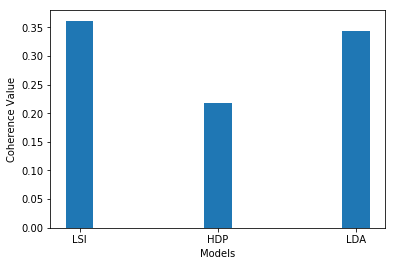

In [112]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

We can see that topic coherence helped us get past manually inspecting our topic models - we can now keep fine tuning our models and compare between them to see which has the best performance.

This is a particularly small example of a corpus for illustration purposes. Another example could be a list of all the plays written by Shakespeare, list of all wikipedia articles, or all tweets by a particular person of interest.

After collecting our corpus, there are typically a number of preprocessing steps we want to undertake. We'll keep it simple and just remove some commonly used English words (such as 'the') and words that occur only once in the corpus. In the process of doing so, we'll [tokenise][1] our data. Tokenization breaks up the documents into words (in this case using space as a delimiter).
[1]: https://en.wikipedia.org/wiki/Tokenization_(lexical_analysis)